In [1]:
import pandas as pd
import numpy as np
import hashlib
import psycopg2
from sqlalchemy import create_engine
import warnings

In [2]:
def crear_dataframe_enriquecido_desde_db(db_params, period_order, period_order_name):
    """
    Se conecta a la base de datos, extrae y une datos de calificaciones y grupos,
    y enriquece el DataFrame resultante con información contextual de los períodos.

    Args:
        db_params (dict): Diccionario con las credenciales de la base de datos.
        period_order (list): Lista de IDs de los períodos.
        period_order_name (list): Lista de nombres de los períodos.

    Returns:
        pd.DataFrame: Un único DataFrame enriquecido y listo para el análisis, o None si falla.
    """
    print("Iniciando el proceso de creación del DataFrame...")

    try:
        print("Estableciendo conexión con la base de datos PostgreSQL...")
        engine_url = f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}/{db_params['dbname']}"
        engine = create_engine(engine_url)
        
        sql_query = """
        SELECT
            c.matricula,
            g.id_carrera,
            c.id_grupo,
            c.id_materia,
            g.semestre,
            g.id_periodo AS periodo,
            -- Calificaciones
            c.p1, c.p2, c.p3, c.o, c.pf, c.e1, c.e2, c.esp,
            -- Asistencias
            c.a1, c.a2, c.a3, c.oa, c.pa
        FROM
            nes_calificaciones AS c
        JOIN
            nes_grupos AS g ON c.id_grupo = g.id_grupo;
        """
        
        print("Ejecutando consulta SQL para extraer y unir los datos...")
        df = pd.read_sql(sql_query, engine)
        print(f"Consulta completada. Se extrajeron {len(df)} registros.")

    except Exception as e:
        print(f"ERROR: No se pudo conectar a la base de datos o ejecutar la consulta: {e}")
        return None

    print("\nCreando identificador único 'alumno_carrera_id' y anonimizando...")
    df['alumno_carrera_id'] = df['matricula'].astype(str) + '_' + df['id_carrera'].astype(str)
    
    df['alumno_carrera_hash'] = df['alumno_carrera_id'].apply(
        lambda x: hashlib.sha256(x.encode()).hexdigest()
    )

    df = df.drop(columns=['matricula', 'alumno_carrera_id'])
    
    print("Enriqueciendo el DataFrame con información contextual de los períodos...")
    period_name_map = dict(zip(period_order, period_order_name))
    df['nombre_periodo'] = df['periodo'].map(period_name_map)
    
    unmapped_periods = df[df['nombre_periodo'].isnull()]['periodo'].unique()
    if len(unmapped_periods) > 0:
        print(f"ADVERTENCIA: Los siguientes IDs de período no se encontraron en el mapeo: {unmapped_periods}")

    df['año_academico'] = df['nombre_periodo'].str[:9]
    df['tipo_periodo'] = df['nombre_periodo'].str[-1]
    
    conditions = [
        df['tipo_periodo'] == 'A',
        df['tipo_periodo'] == 'B',
        df['tipo_periodo'] == 'V'
    ]
    choices = ['Impar', 'Par', 'Recursamiento']
    df['tipo_semestre'] = np.select(conditions, choices, default='Desconocido')
    
    df['es_periodo_regular'] = df['tipo_periodo'].isin(['A', 'B'])
    
    print("¡Proceso completado exitosamente!")
    
    return df

In [3]:
db_credentials = {
        "host": "localhost",
        "dbname": "NES",
        "user": "postgres",
        "password": "x"
    }

In [4]:
period_order = [35, 36, 40, 39, 42, 43, 41, 46, 47, 44, 49, 50, 48, 53, 54, 51, 52, 56, 55, 58, 59, 57, 61]
period_order_name = [
    "2017-2018A", "2017-2018B", "2017-2018V", "2018-2019A", "2018-2019B", "2018-2019V", 
    "2019-2020A", "2019-2020B", "2019-2020V", "2020-2021A", "2020-2021B", "2020-2021V", 
    "2021-2022A", "2021-2022B", "2021-2022V", "2022-2023A", "2022-2023B", "2022-2023V", 
    "2023-2024A", "2023-2024B", "2023-2024V", "2024-2025A", "2024-2025B"
]

In [5]:
df_final = crear_dataframe_enriquecido_desde_db(db_credentials, period_order, period_order_name)

Iniciando el proceso de creación del DataFrame...
Estableciendo conexión con la base de datos PostgreSQL...
Ejecutando consulta SQL para extraer y unir los datos...
Consulta completada. Se extrajeron 133882 registros.

Creando identificador único 'alumno_carrera_id' y anonimizando...
Enriqueciendo el DataFrame con información contextual de los períodos...
¡Proceso completado exitosamente!


In [6]:
if df_final is not None:
        print("\n--- Vista Previa del DataFrame Final (primeras 5 filas) ---")
        print(df_final.head())
        
        print("\n--- Columnas del DataFrame Final ---")
        print(df_final.columns.tolist())
        
        print(f"\nDimensiones del DataFrame: {df_final.shape[0]} filas, {df_final.shape[1]} columnas.")


--- Vista Previa del DataFrame Final (primeras 5 filas) ---
   id_carrera  id_grupo  id_materia  semestre  periodo    p1    p2    p3  \
0           2      2975       13710         2       61 -10.0 -10.0 -10.0   
1           2      2975       13710         2       61 -10.0 -10.0 -10.0   
2           2      2975       13710         2       61 -10.0 -10.0 -10.0   
3           2      2975       13710         2       61 -10.0 -10.0 -10.0   
4           2      2975       13710         2       61 -10.0 -10.0 -10.0   

      o   pf  ...    a2    a3    oa    pa  \
0 -10.0  0.0  ... -10.0 -10.0 -10.0  25.0   
1 -10.0  0.0  ... -10.0 -10.0 -10.0  25.0   
2 -10.0  0.0  ... -10.0 -10.0 -10.0  22.0   
3 -10.0  0.0  ... -10.0 -10.0 -10.0  23.0   
4 -10.0  0.0  ... -10.0 -10.0 -10.0  25.0   

                                 alumno_carrera_hash  nombre_periodo  \
0  a0bb973b0416d3f4ceb601a627c9c9d99d46f306ccd699...      2024-2025B   
1  578d25e52a24ac996077afc11adb90698d500737270aac...      2024-2025

In [7]:
columnas_numericas = [
    'p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp', 'a1', 'a2', 'a3', 'oa', 'pa'
]

In [8]:
estadisticas = df_final[columnas_numericas].agg(['mean', 'median', 'min', 'max', 'std']).transpose()
estadisticas = estadisticas.rename(columns={
    'mean': 'Media',
    'median': 'Mediana',
    'min': 'Mínimo',
    'max': 'Máximo',
    'std': 'Desviación estándar'
})

print(estadisticas)

         Media  Mediana  Mínimo  Máximo  Desviación estándar
p1    6.455435      7.4   -10.0    10.0             3.621790
p2    5.674854      7.3   -10.0    10.0             5.093707
p3    5.553593      7.4   -10.0    10.0             5.324765
o     5.649781      7.8   -10.0    10.0             5.492562
pf    6.360659      7.4   -10.0    10.0             3.398940
e1   -8.176267    -10.0   -10.0    10.0             4.833230
e2   -9.053577    -10.0   -10.0    10.0             3.511815
esp  -9.887169    -10.0   -10.0    10.0             1.262861
a1   95.093627    100.0   -10.0   100.0            16.237960
a2   88.916889    100.0   -10.0   100.0            28.218431
a3   87.364030    100.0   -10.0   100.0            29.923044
oa   81.174848    100.0   -10.0   100.0            39.191282
pa   89.868541     98.0   -10.0   100.0            22.989811


In [9]:
def limpiar_calificaciones_invalidas(df):
    """
    Reemplaza los valores negativos en las columnas de calificación y asistencia
    con np.nan para representar correctamente los datos faltantes.
    """
    print("Iniciando limpieza de valores negativos...")
    
    columnas_a_limpiar = [
        'p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp',
        'a1', 'a2', 'a3', 'oa', 'pa'
    ]
    
    columnas_existentes = [col for col in columnas_a_limpiar if col in df.columns]
    
    df[columnas_existentes] = df[columnas_existentes].mask(df[columnas_existentes] < 0, np.nan)
    
    print(f"Limpieza completada. Se procesaron {len(columnas_existentes)} columnas.")
    return df

In [10]:
def crear_dataframe_enriquecido_desde_db_limpio(db_params, period_order, period_order_name):
    """
    Se conecta a la BD, extrae, limpia, transforma y enriquece los datos de los alumnos.

    Args:
        db_params (dict): Diccionario con las credenciales de la base de datos.
        period_order (list): Lista de IDs de los períodos.
        period_order_name (list): Lista de nombres de los períodos.

    Returns:
        pd.DataFrame: Un único DataFrame listo para el análisis, o None si falla.
    """
    print("Iniciando el proceso de creación del DataFrame...")

    try:
        print("Estableciendo conexión con la base de datos PostgreSQL...")
        engine_url = f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}/{db_params['dbname']}"
        engine = create_engine(engine_url)
        
        sql_query = """
        SELECT
            c.matricula,
            g.id_carrera,
            c.id_grupo,
            c.id_materia,
            g.semestre,
            g.id_periodo AS periodo,
            -- Calificaciones
            c.p1, c.p2, c.p3, c.o, c.pf, c.e1, c.e2, c.esp,
            -- Asistencias
            c.a1, c.a2, c.a3, c.oa, c.pa
        FROM
            nes_calificaciones AS c
        JOIN
            nes_grupos AS g ON c.id_grupo = g.id_grupo;
        """
        
        print("Ejecutando consulta SQL para extraer y unir los datos...")
        df = pd.read_sql(sql_query, engine)
        print(f"Consulta completada. Se extrajeron {len(df)} registros.")

    except Exception as e:
        print(f"ERROR: No se pudo conectar a la base de datos o ejecutar la consulta: {e}")
        return None

    df = limpiar_calificaciones_invalidas(df)

    print("\nCreando identificador único 'alumno_carrera_id' y anonimizando...")
    df['alumno_carrera_id'] = df['matricula'].astype(str) + '_' + df['id_carrera'].astype(str)
    
    df['alumno_carrera_hash'] = df['alumno_carrera_id'].apply(
        lambda x: hashlib.sha256(x.encode()).hexdigest()
    )
    df = df.drop(columns=['matricula', 'alumno_carrera_id'])
    
    print("Enriqueciendo el DataFrame con información contextual de los períodos...")
    period_name_map = dict(zip(period_order, period_order_name))
    df['nombre_periodo'] = df['periodo'].map(period_name_map)
    
    unmapped_periods = df[df['nombre_periodo'].isnull()]['periodo'].unique()
    if len(unmapped_periods) > 0:
        print(f"ADVERTENCIA: Los siguientes IDs de período no se encontraron en el mapeo: {unmapped_periods}")

    df['año_academico'] = df['nombre_periodo'].str[:9]
    df['tipo_periodo'] = df['nombre_periodo'].str[-1]
    
    conditions = [
        df['tipo_periodo'] == 'A',
        df['tipo_periodo'] == 'B',
        df['tipo_periodo'] == 'V'
    ]
    choices = ['Impar', 'Par', 'Recursamiento']
    df['tipo_semestre'] = np.select(conditions, choices, default='Desconocido')
    
    df['es_periodo_regular'] = df['tipo_periodo'].isin(['A', 'B'])
    
    print("¡Proceso completado exitosamente!")
    
    return df

In [11]:
df_final_limpio = crear_dataframe_enriquecido_desde_db_limpio(db_credentials, period_order, period_order_name)

Iniciando el proceso de creación del DataFrame...
Estableciendo conexión con la base de datos PostgreSQL...
Ejecutando consulta SQL para extraer y unir los datos...
Consulta completada. Se extrajeron 133882 registros.
Iniciando limpieza de valores negativos...
Limpieza completada. Se procesaron 13 columnas.

Creando identificador único 'alumno_carrera_id' y anonimizando...
Enriqueciendo el DataFrame con información contextual de los períodos...
¡Proceso completado exitosamente!


In [12]:
if df_final_limpio is not None:
        print("\n--- Vista Previa del DataFrame Final (primeras 5 filas) ---")
        print(df_final_limpio.head())
        
        print("\n--- Estadísticas Descriptivas (Después de la limpieza) ---")
        print(df_final_limpio[['p1', 'p2', 'p3', 'o','pf', 'a1', 'a2', 'a3', 'oa', 'pa']].describe())


--- Vista Previa del DataFrame Final (primeras 5 filas) ---
   id_carrera  id_grupo  id_materia  semestre  periodo  p1  p2  p3   o   pf  \
0           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
1           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
2           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
3           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
4           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   

   ...  a2  a3  oa    pa                                alumno_carrera_hash  \
0  ... NaN NaN NaN  25.0  a0bb973b0416d3f4ceb601a627c9c9d99d46f306ccd699...   
1  ... NaN NaN NaN  25.0  578d25e52a24ac996077afc11adb90698d500737270aac...   
2  ... NaN NaN NaN  22.0  9b55af95c90111bbbd378f36809598c140d83ab73123c2...   
3  ... NaN NaN NaN  23.0  39fbe56b18793fb13a89906b591f22edb848829b162afa...   
4  ... NaN NaN NaN  25.0  f9e67e37da9e73eed6447e3fb490a95ea80b1ef4013

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
sns.set_theme(style="whitegrid")

def visualizar_histogramas(df):
    """
    Crea y muestra histogramas para las columnas numéricas clave.
    Un histograma nos ayuda a ver la forma y distribución de los datos.
    """
    print("--- Generando Histogramas ---")
    
    columnas_a_visualizar = [
        'p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp',
        'a1', 'a2', 'a3', 'oa', 'pa'
    ]

    nombres_de_columnas = {
        'p1': 'Parcial 1',
        'p2': 'Parcial 2',
        'p3': 'Parcial 3',
        'o': 'Ordinario',
        'pf': 'Promedio final',
        'e1': 'Extraordinario 1',
        'e2': 'Extraordinario 2',
        'esp': 'Examen especial',
        'a1': 'Asistencia parcial 1',
        'a2': 'Asistencia parcial 2',
        'a3': 'Asistencia parcial 3',
        'oa': 'Asistencia de ordinario',
        'pa': 'Porcentaje de asistencia'
    }
    
    fig, axes = plt.subplots(4, 4, figsize=(14, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(columnas_a_visualizar):
        sns.histplot(data=df, x=col, kde=True, ax=axes[i], bins=30)
        axes[i].set_title(f'Distribución de {nombres_de_columnas(col)}', fontsize=14)
        axes[i].set_xlabel('Valor', fontsize=12)
        axes[i].set_ylabel('Frecuencia', fontsize=12)
        
    plt.suptitle('Histogramas de Calificaciones y Asistencias', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

In [15]:
def visualizar_matriz_correlacion(df):
    """
    Calcula y visualiza una matriz de correlación para las variables numéricas.
    Nos ayuda a entender qué tan fuerte es la relación lineal entre dos variables.
    """
    print("\n--- Calculando y Generando Matriz de Correlación ---")
    
    columnas_numericas = [
        'p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp',
        'a1', 'a2', 'a3', 'oa', 'pa'
    ]
    df_numerico = df[columnas_numericas]
    
    matriz_corr = df_numerico.corr(method='pearson')
    
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        matriz_corr,
        annot=False,
        cmap='coolwarm',
        linewidths=0.5
    )
    plt.title('Matriz de Correlación de Calificaciones y Asistencias', fontsize=20)
    plt.show()

--- Generando Histogramas ---


TypeError: 'dict' object is not callable

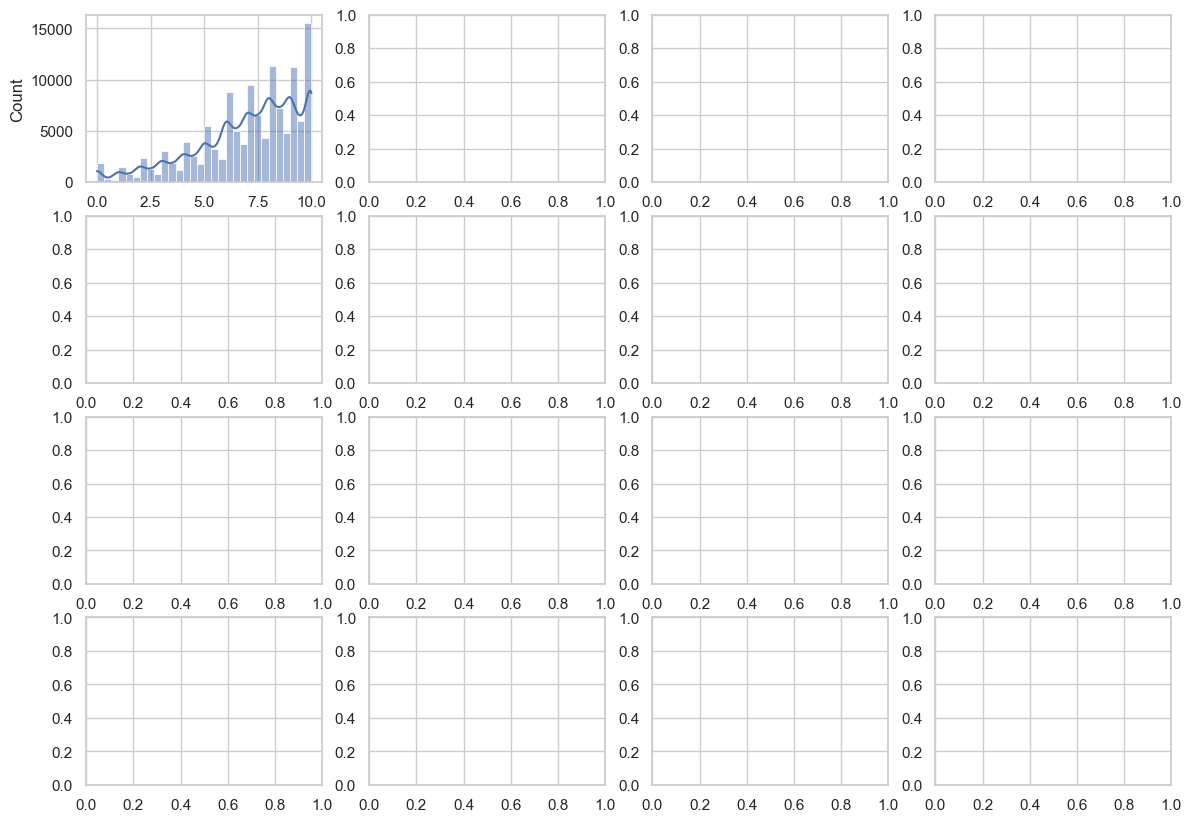

In [53]:
visualizar_histogramas(df_final_limpio)


--- Calculando y Generando Matriz de Correlación ---


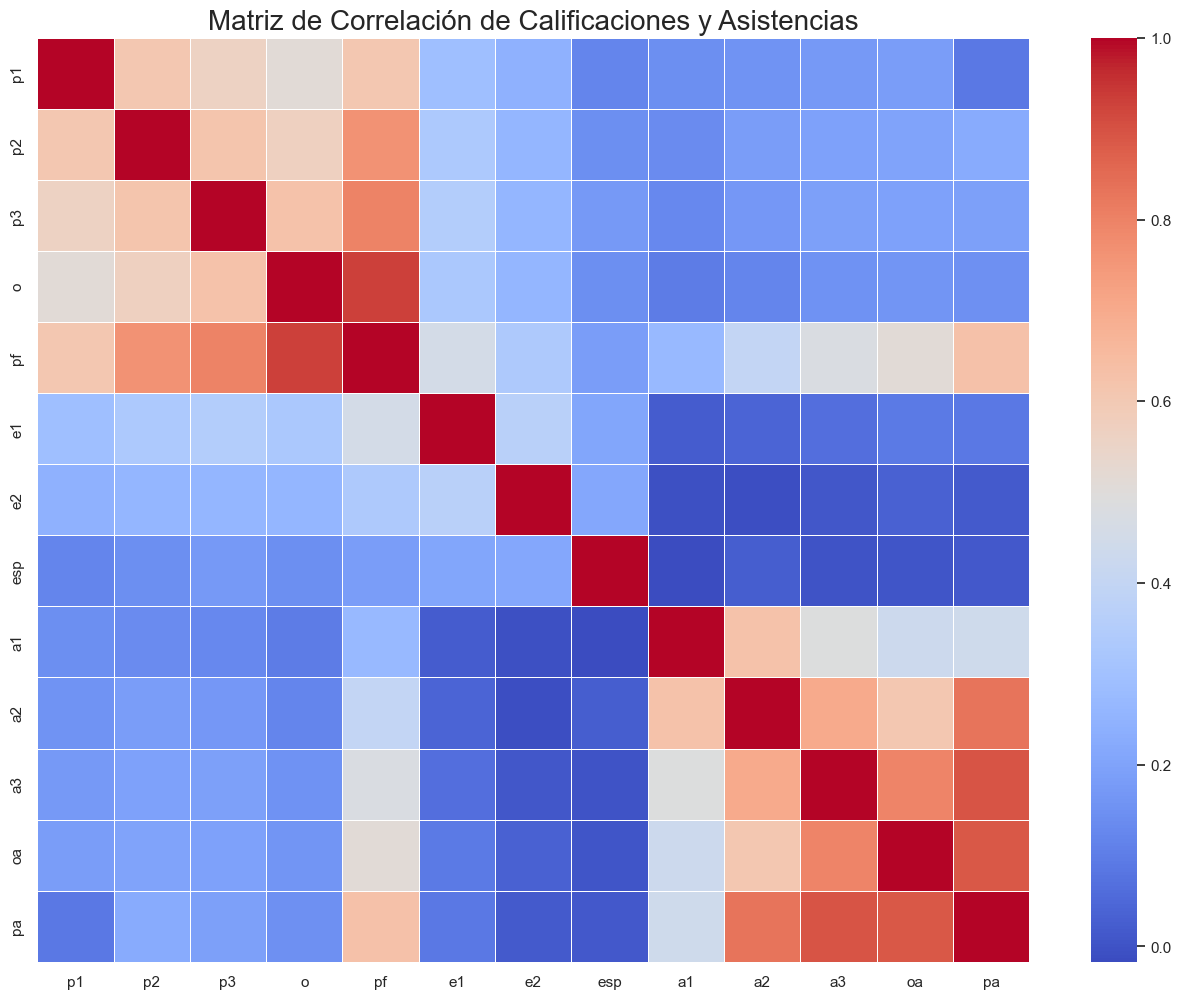

In [17]:
visualizar_matriz_correlacion(df_final_limpio)

In [18]:
def etiquetar_resultado_final(df):
    """
    Etiqueta a los alumnos basándose en si llegaron o no al décimo semestre.

    Args:
        df (pd.DataFrame): El DataFrame completo de datos de estudiantes.

    Returns:
        pd.DataFrame: El DataFrame con la nueva columna 'resultado_final'.
    """
    print("--- Etiquetando alumnos por resultado final (Término / Deserción) ---")

    hashes_termino = set(df[df['semestre'] == 10]['alumno_carrera_hash'].unique())
    
    print(f"Se encontraron {len(hashes_termino)} alumnos que llegaron a 10mo semestre.")

    df['resultado_final'] = df['alumno_carrera_hash'].isin(hashes_termino).astype(int)

    print("Columna 'resultado_final' creada exitosamente.")
    print("1 = Término, 0 = Desertó")
    
    return df

In [19]:
df_etiquetado = etiquetar_resultado_final(df_final_limpio)

--- Etiquetando alumnos por resultado final (Término / Deserción) ---
Se encontraron 1944 alumnos que llegaron a 10mo semestre.
Columna 'resultado_final' creada exitosamente.
1 = Término, 0 = Desertó


In [20]:
print("\n--- Vista Previa del DataFrame Final (primeras 5 filas) ---")
print(df_etiquetado.head())


--- Vista Previa del DataFrame Final (primeras 5 filas) ---
   id_carrera  id_grupo  id_materia  semestre  periodo  p1  p2  p3   o   pf  \
0           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
1           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
2           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
3           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
4           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   

   ...  a3  oa    pa                                alumno_carrera_hash  \
0  ... NaN NaN  25.0  a0bb973b0416d3f4ceb601a627c9c9d99d46f306ccd699...   
1  ... NaN NaN  25.0  578d25e52a24ac996077afc11adb90698d500737270aac...   
2  ... NaN NaN  22.0  9b55af95c90111bbbd378f36809598c140d83ab73123c2...   
3  ... NaN NaN  23.0  39fbe56b18793fb13a89906b591f22edb848829b162afa...   
4  ... NaN NaN  25.0  f9e67e37da9e73eed6447e3fb490a95ea80b1ef401301d...   

   nombre_per

In [21]:
def analisis_univariable_por_carrera(df, columna='pf'):
    """
    Realiza un análisis univariable creando un histograma de las calificaciones
    finales (pf) para cada carrera.
    """
    print("--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---")
    
    if 'id_carrera' not in df.columns or 'pf' not in df.columns:
        print("ERROR: El DataFrame debe contener las columnas 'id_carrera' y 'pf'.")
        return
        
    g = sns.FacetGrid(df, col="id_carrera", col_wrap=4, height=4, sharex=True, sharey=False)
    
    g.map(sns.histplot, columna, kde=True, bins=20)
    
    g.fig.suptitle('Distribución de Calificaciones por Carrera: ' + columna, y=1.02, fontsize=20)
    g.set_axis_labels("Promedio (" + columna + ')', "Frecuencia")
    g.set_titles("Carrera: {col_name}")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [22]:
def analisis_bivariable_por_carrera(df, columna1='pf', columna2='pa'):
    """
    Realiza un análisis bivariable creando un gráfico de dispersión
    entre dos columnas para cada carrera, añadiendo una tabla de simbología.
    """
    print("\n--- 2. Iniciando Análisis Bivariable por Carrera ---")

    if 'id_carrera' not in df.columns or columna1 not in df.columns or columna2 not in df.columns:
        print(f"ERROR: El DataFrame debe contener 'id_carrera', '{columna1}' y '{columna2}'.")
        return

    g = sns.FacetGrid(df, col="id_carrera", col_wrap=4, height=4, sharex=True, sharey=True)
    g.map(sns.scatterplot, columna2, columna1, alpha=0.5)
    g.map(sns.regplot, columna2, columna1, scatter=False, color='red')

    g.fig.suptitle(f'Relación {columna1} vs. {columna2} por Carrera', y=1.03, fontsize=20)
    g.set_axis_labels(f"Promedio ({columna2})", f"Promedio ({columna1})")
    g.set_titles("Carrera: {col_name}")

    symbology_text = (
        'Simbología:\n'
        '  ● Puntos Azules: Datos individuales\n'
        '  ─ Línea Roja: Tendencia de los datos'
    )

    plt.figtext(
        0.75, 0.90,
        symbology_text,
        ha="left",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="black", lw=1, alpha=0.9)
    )
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\913075889.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


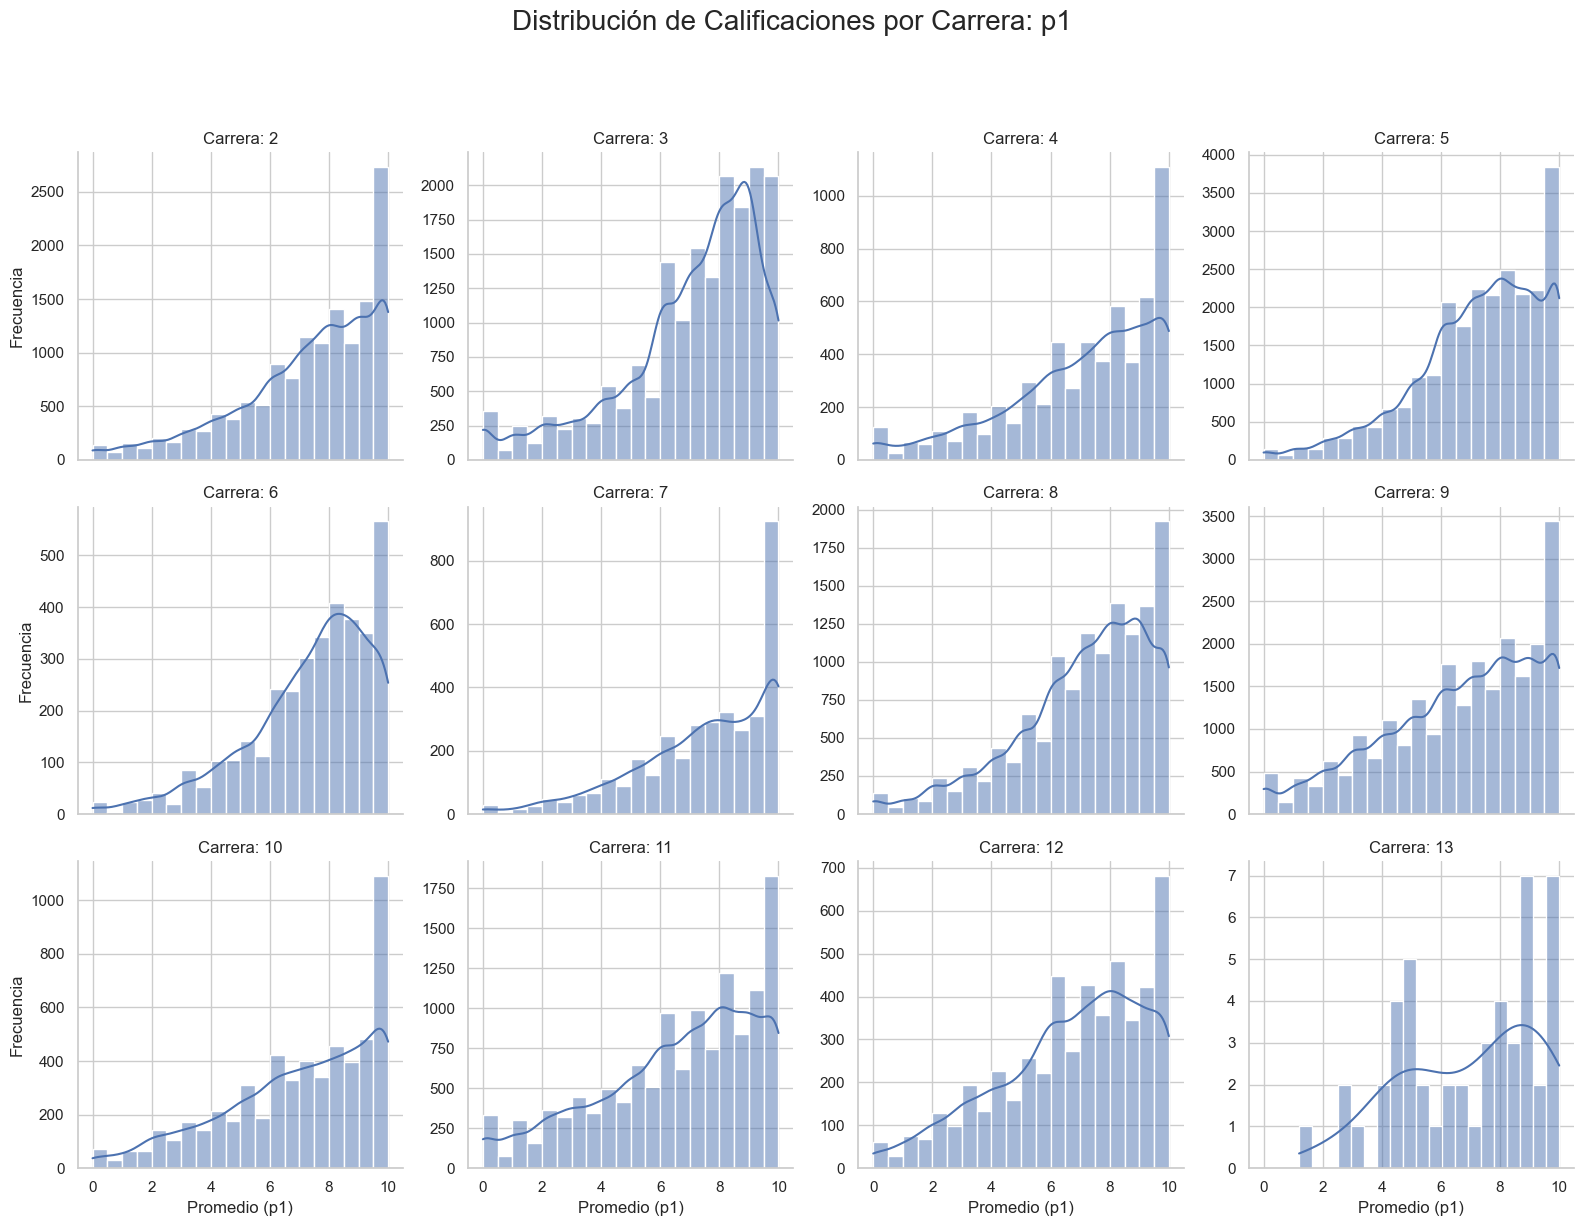

In [23]:
analisis_univariable_por_carrera(df_etiquetado, columna='p1')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\913075889.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


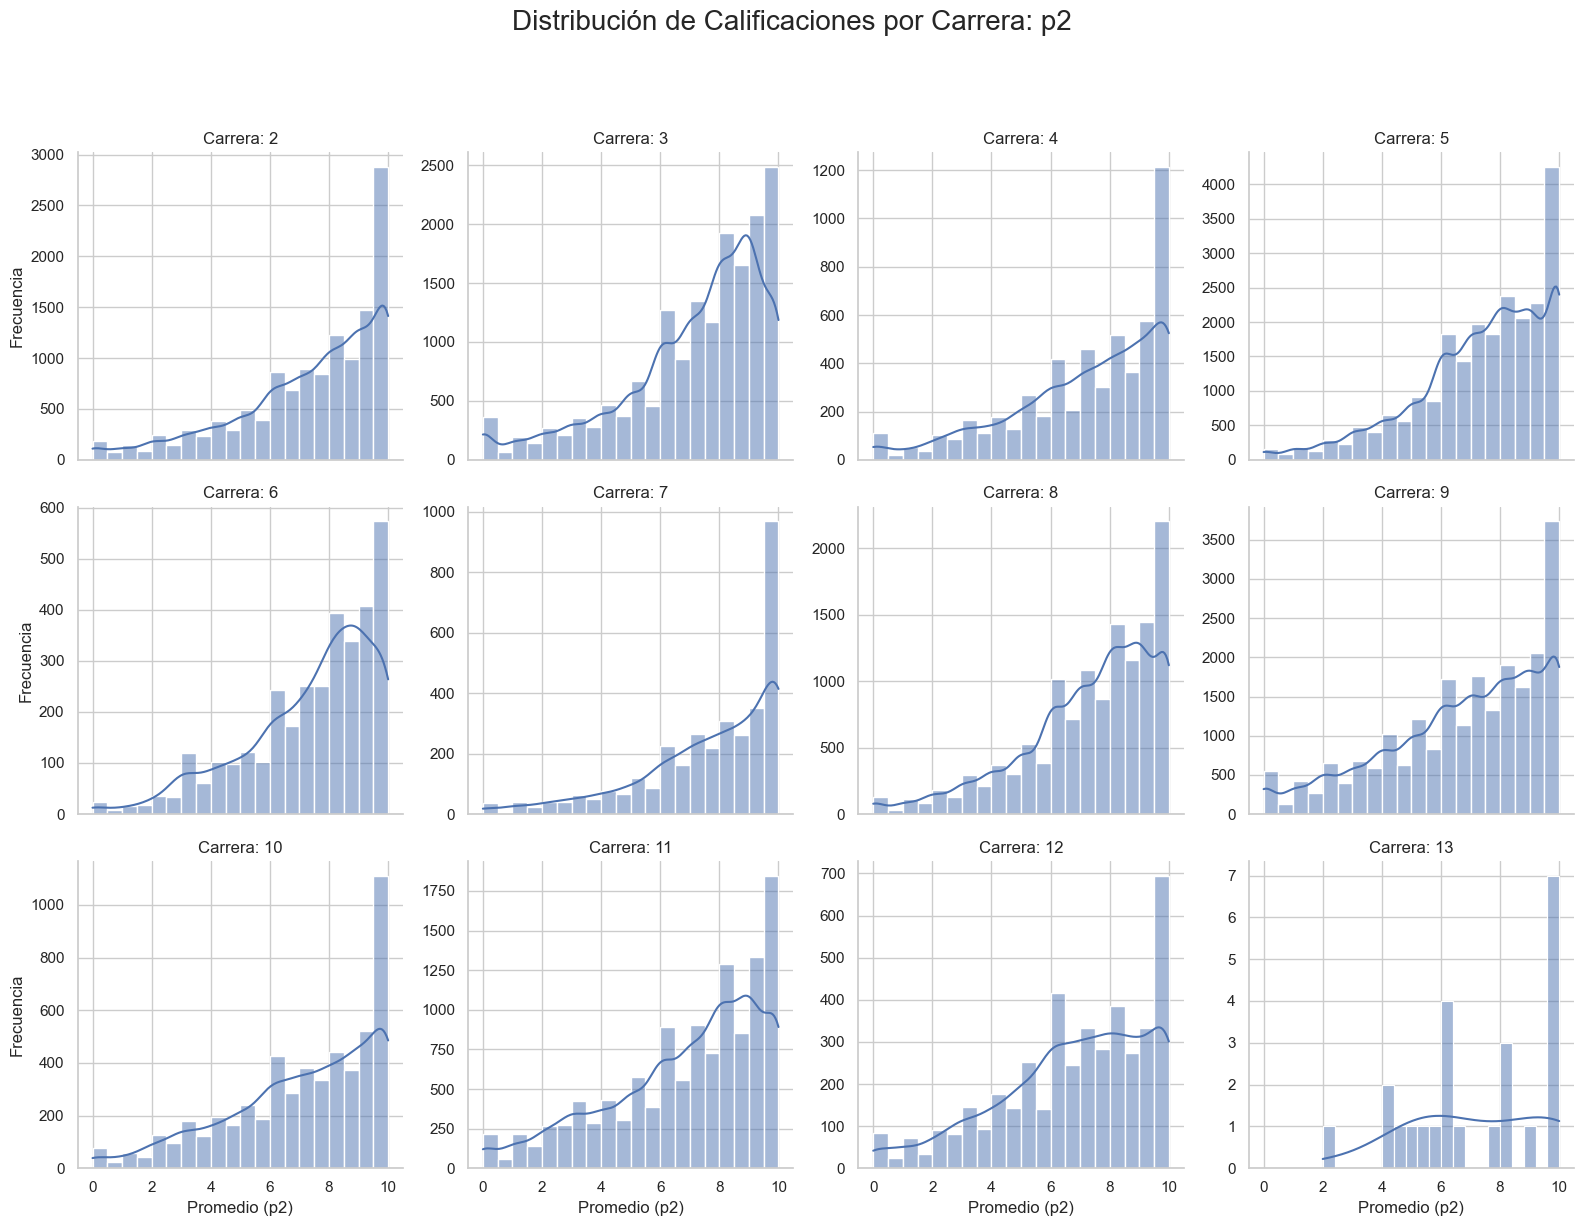

In [24]:
analisis_univariable_por_carrera(df_etiquetado, columna='p2')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\913075889.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


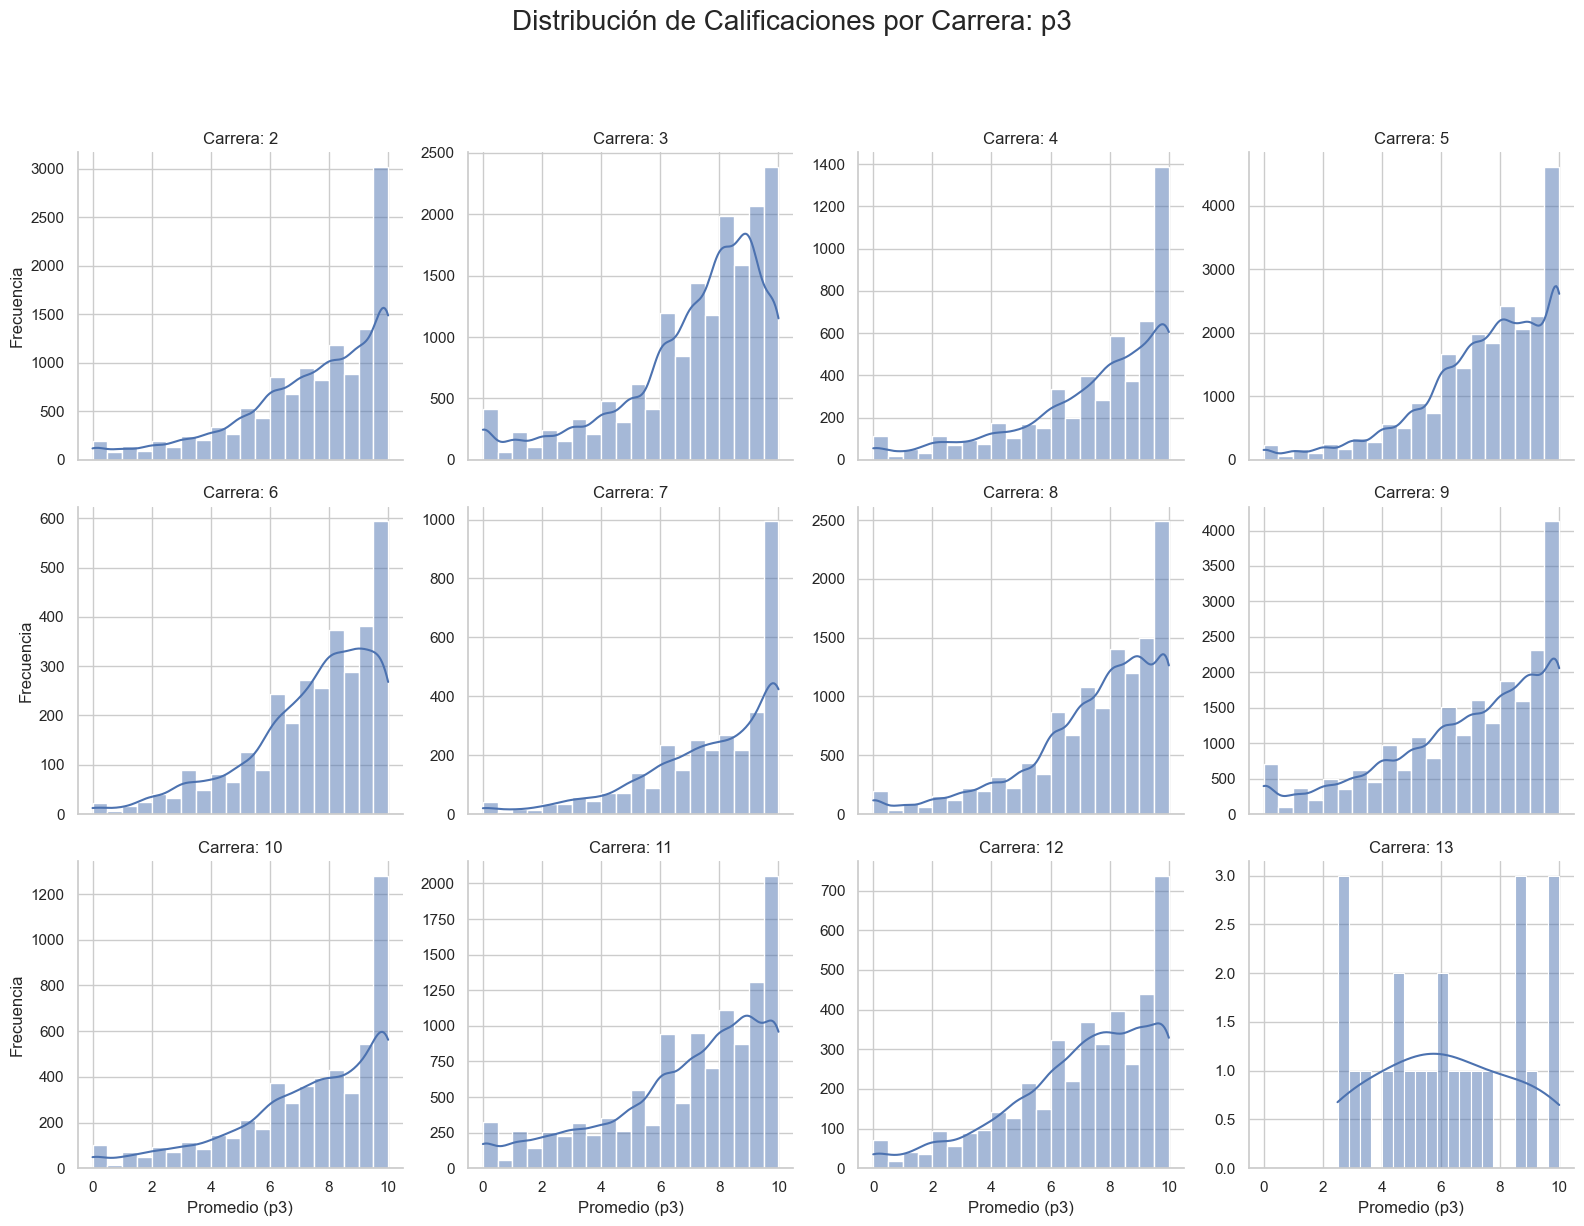

In [25]:
analisis_univariable_por_carrera(df_etiquetado, columna='p3')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\913075889.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


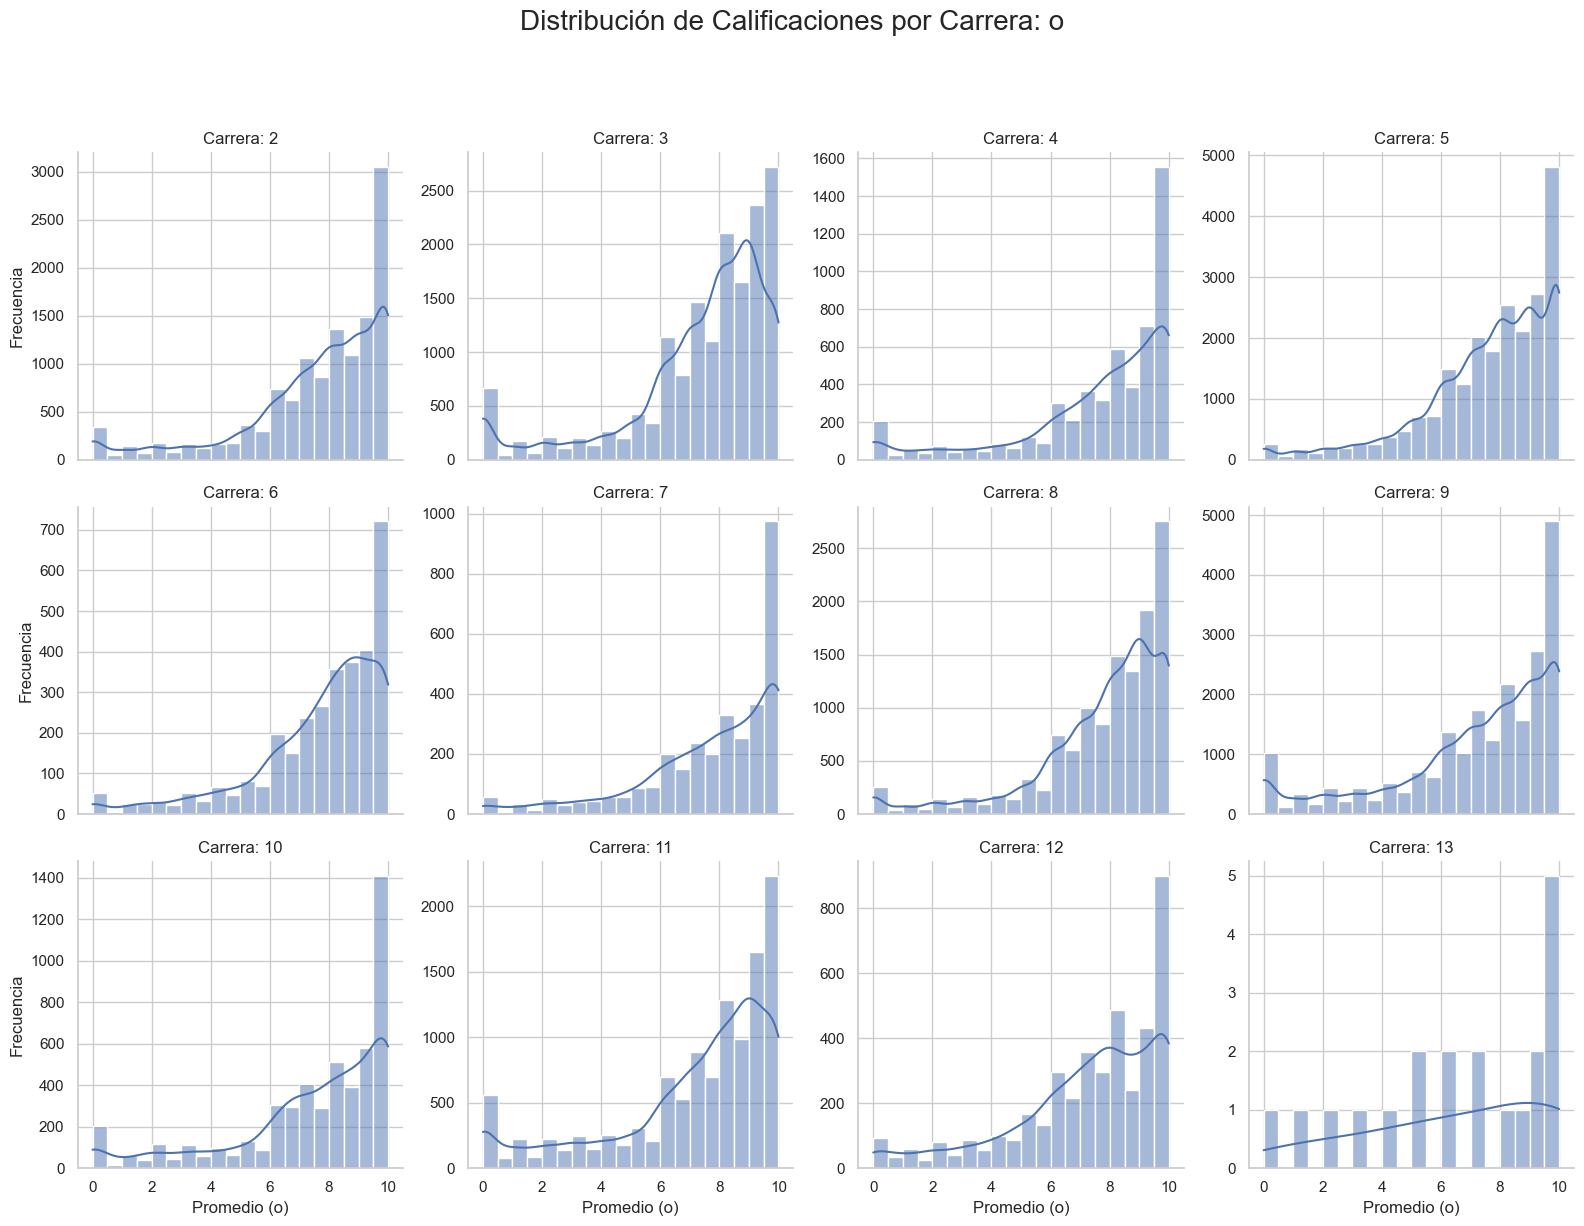

In [26]:
analisis_univariable_por_carrera(df_etiquetado, columna='o')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\913075889.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


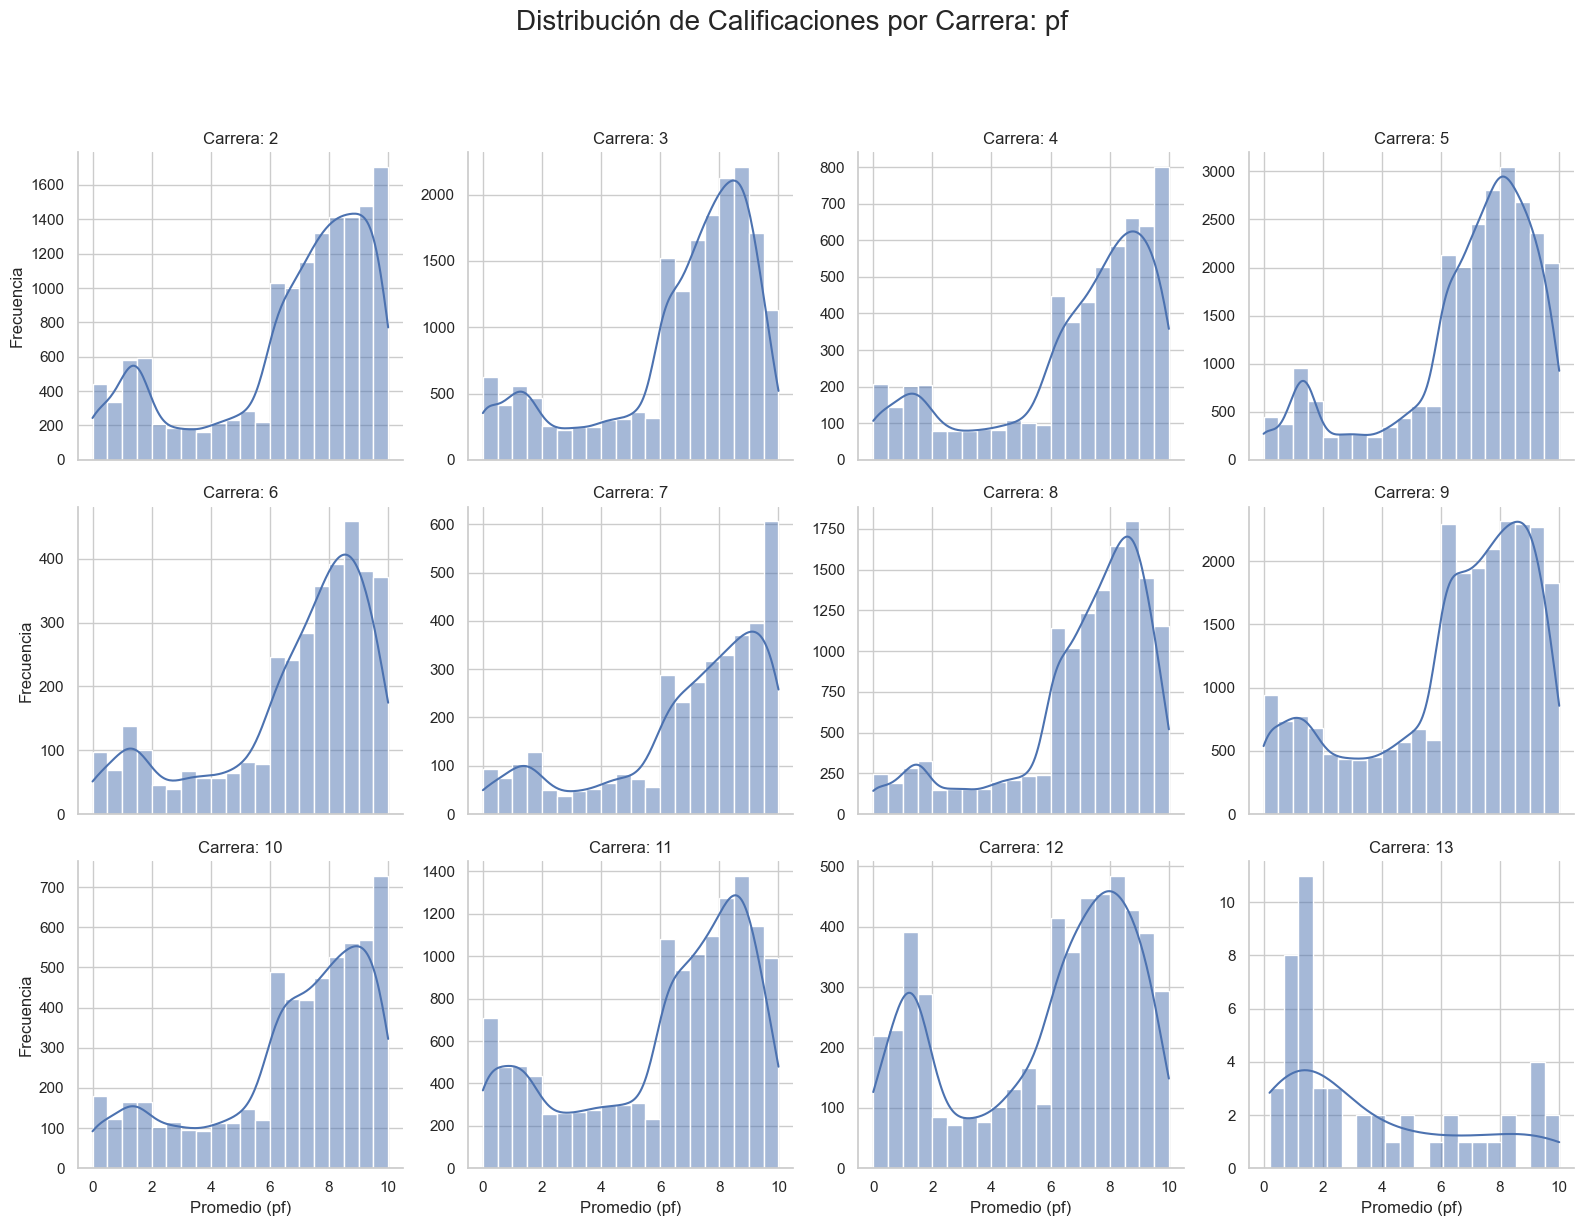

In [27]:
analisis_univariable_por_carrera(df_etiquetado, columna='pf')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\913075889.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


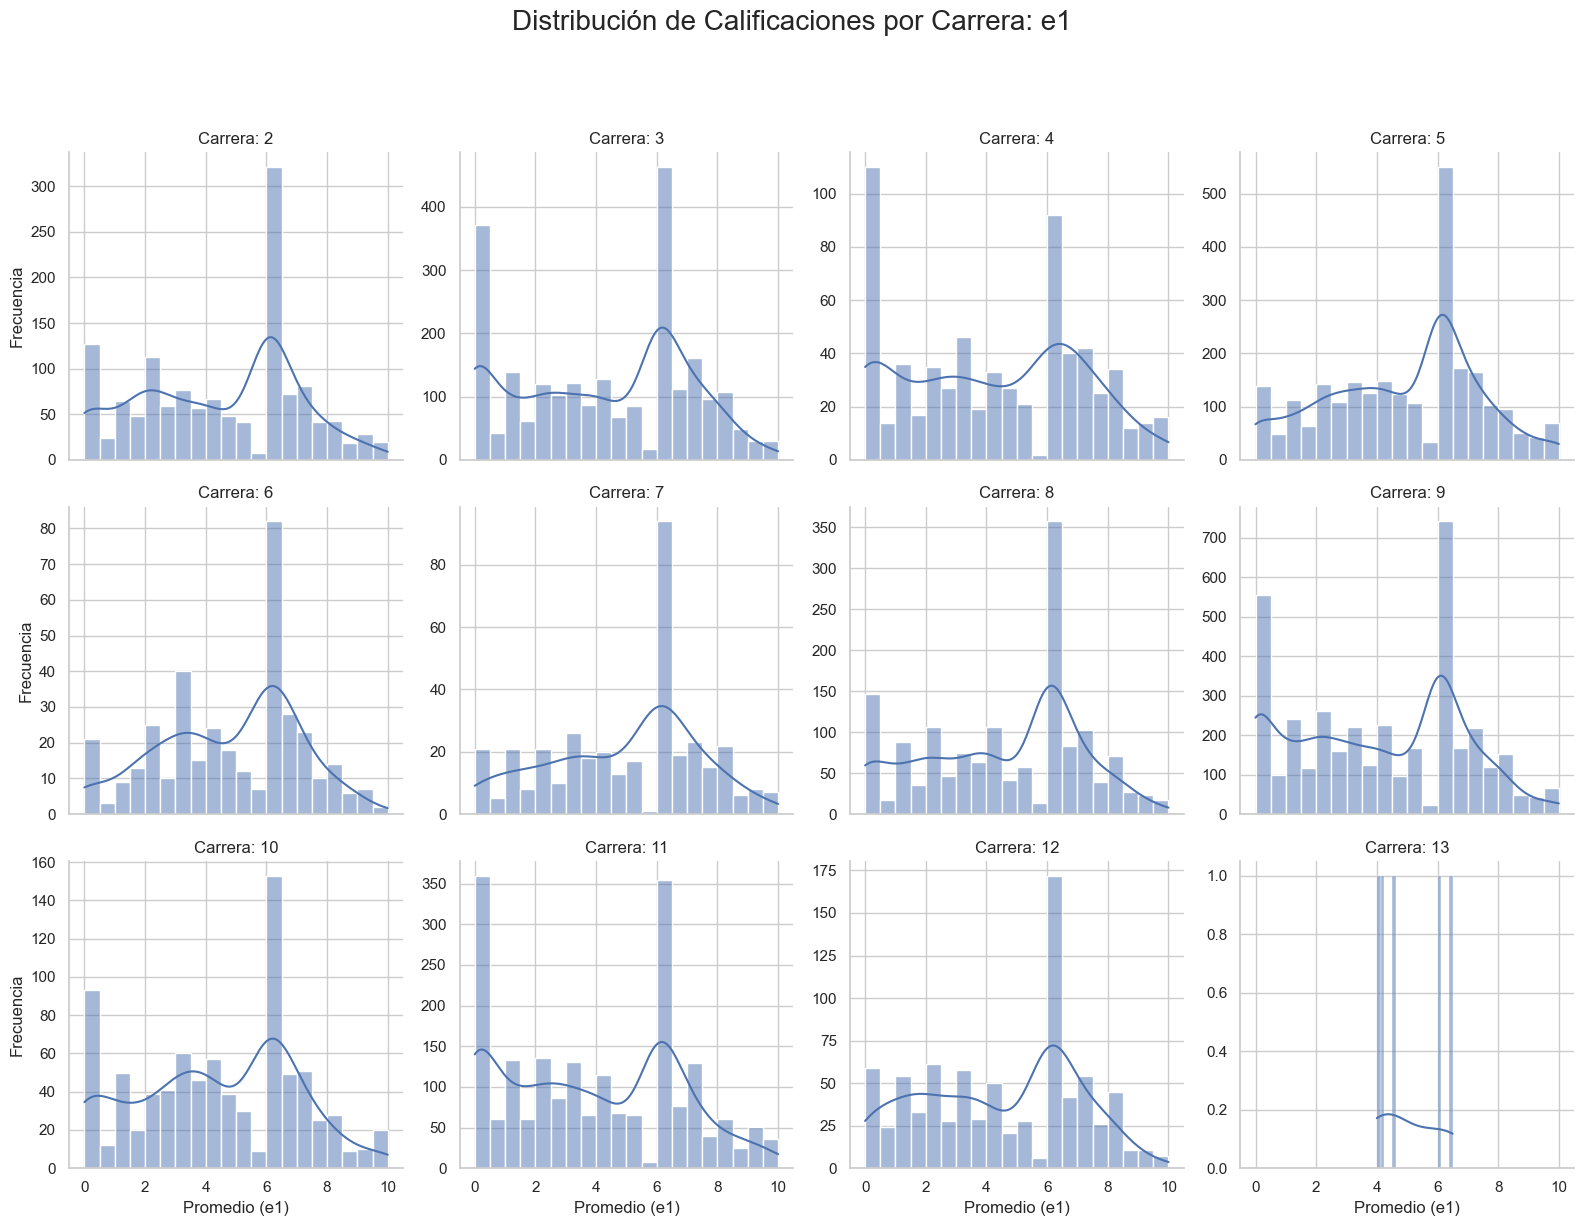

In [28]:
analisis_univariable_por_carrera(df_etiquetado, columna='e1')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\913075889.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


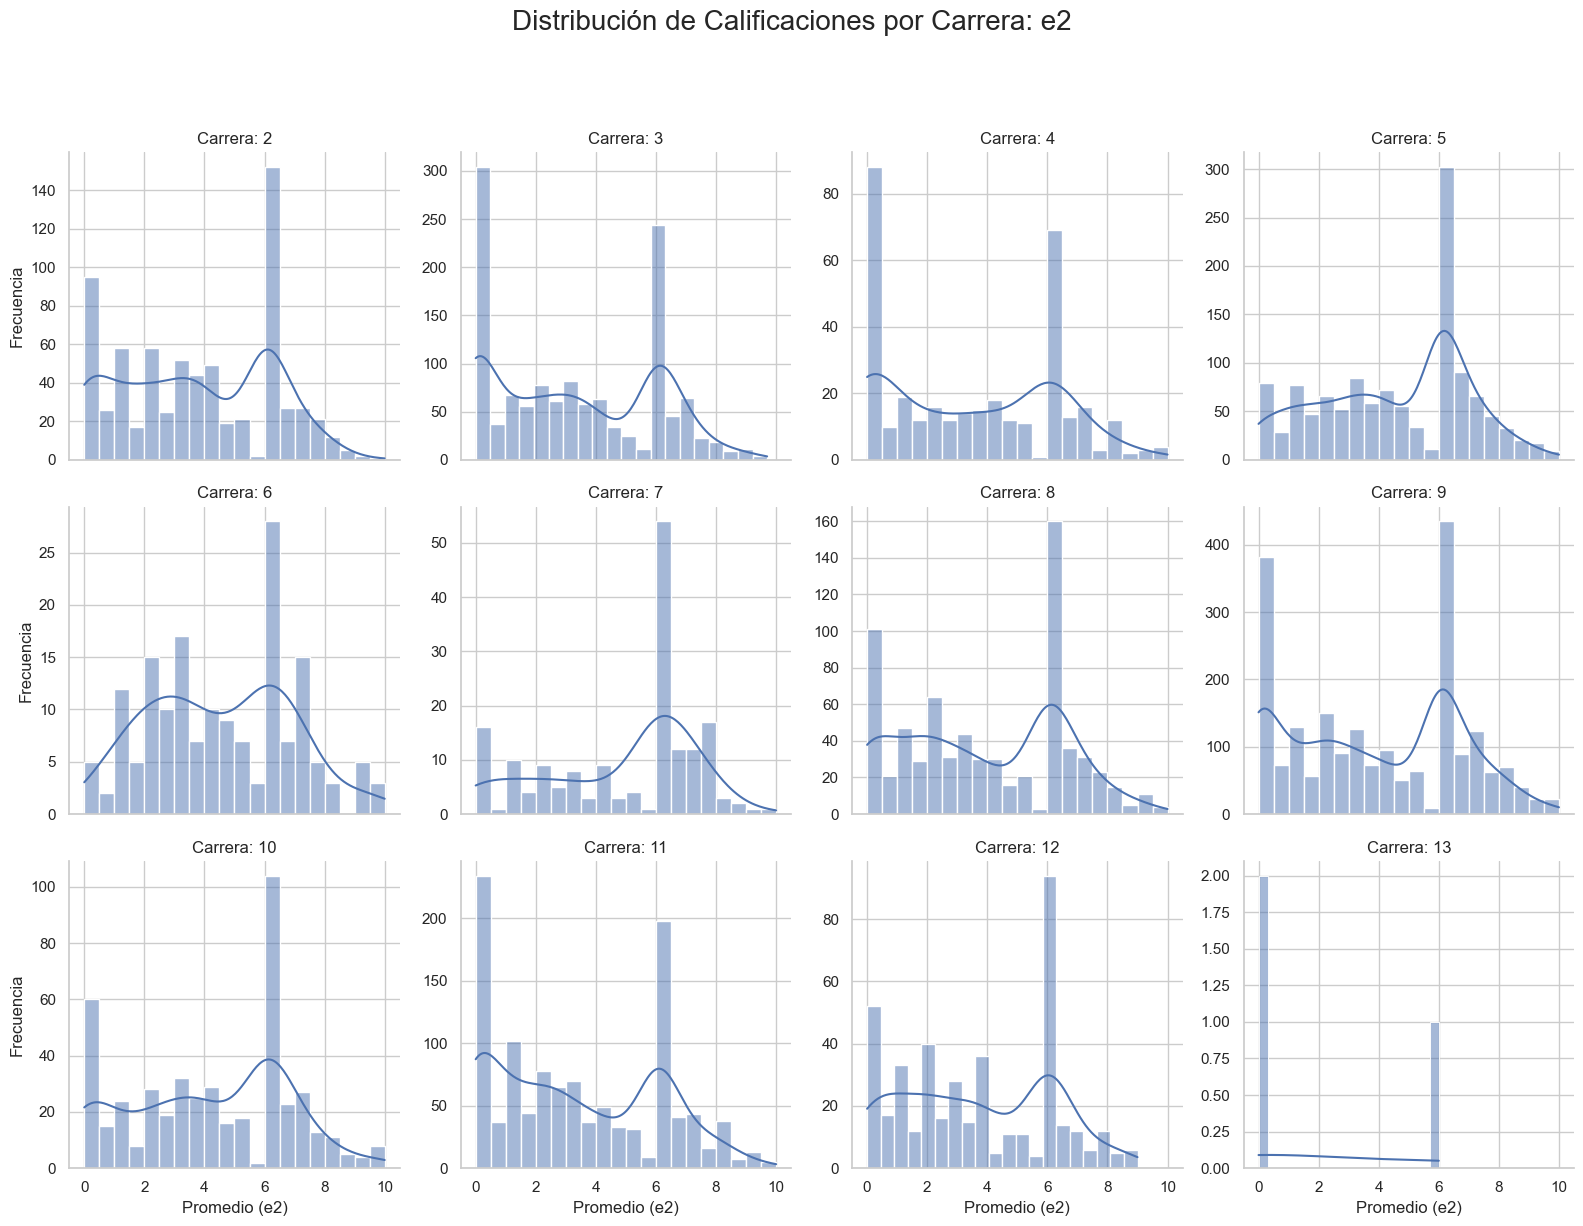

In [29]:
analisis_univariable_por_carrera(df_etiquetado, columna='e2')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\913075889.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


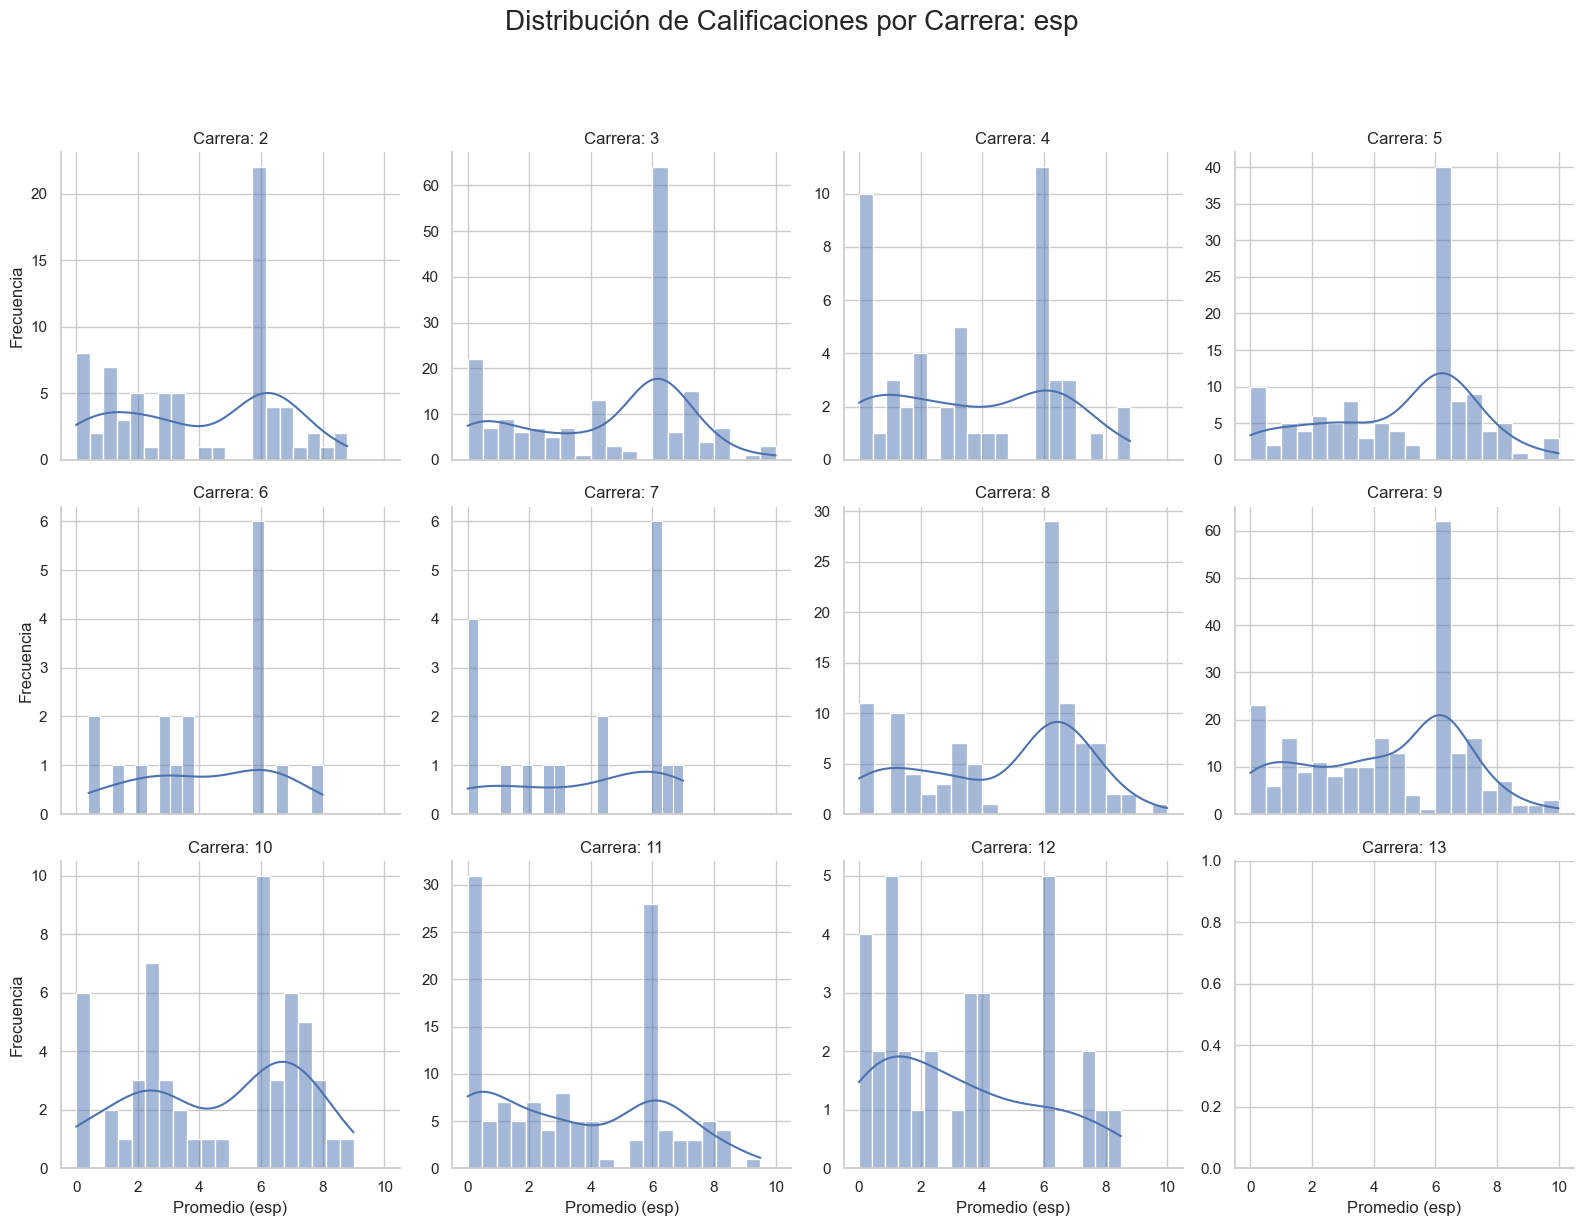

In [30]:
analisis_univariable_por_carrera(df_etiquetado, columna='esp')


--- 2. Iniciando Análisis Bivariable por Carrera ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\3493294603.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


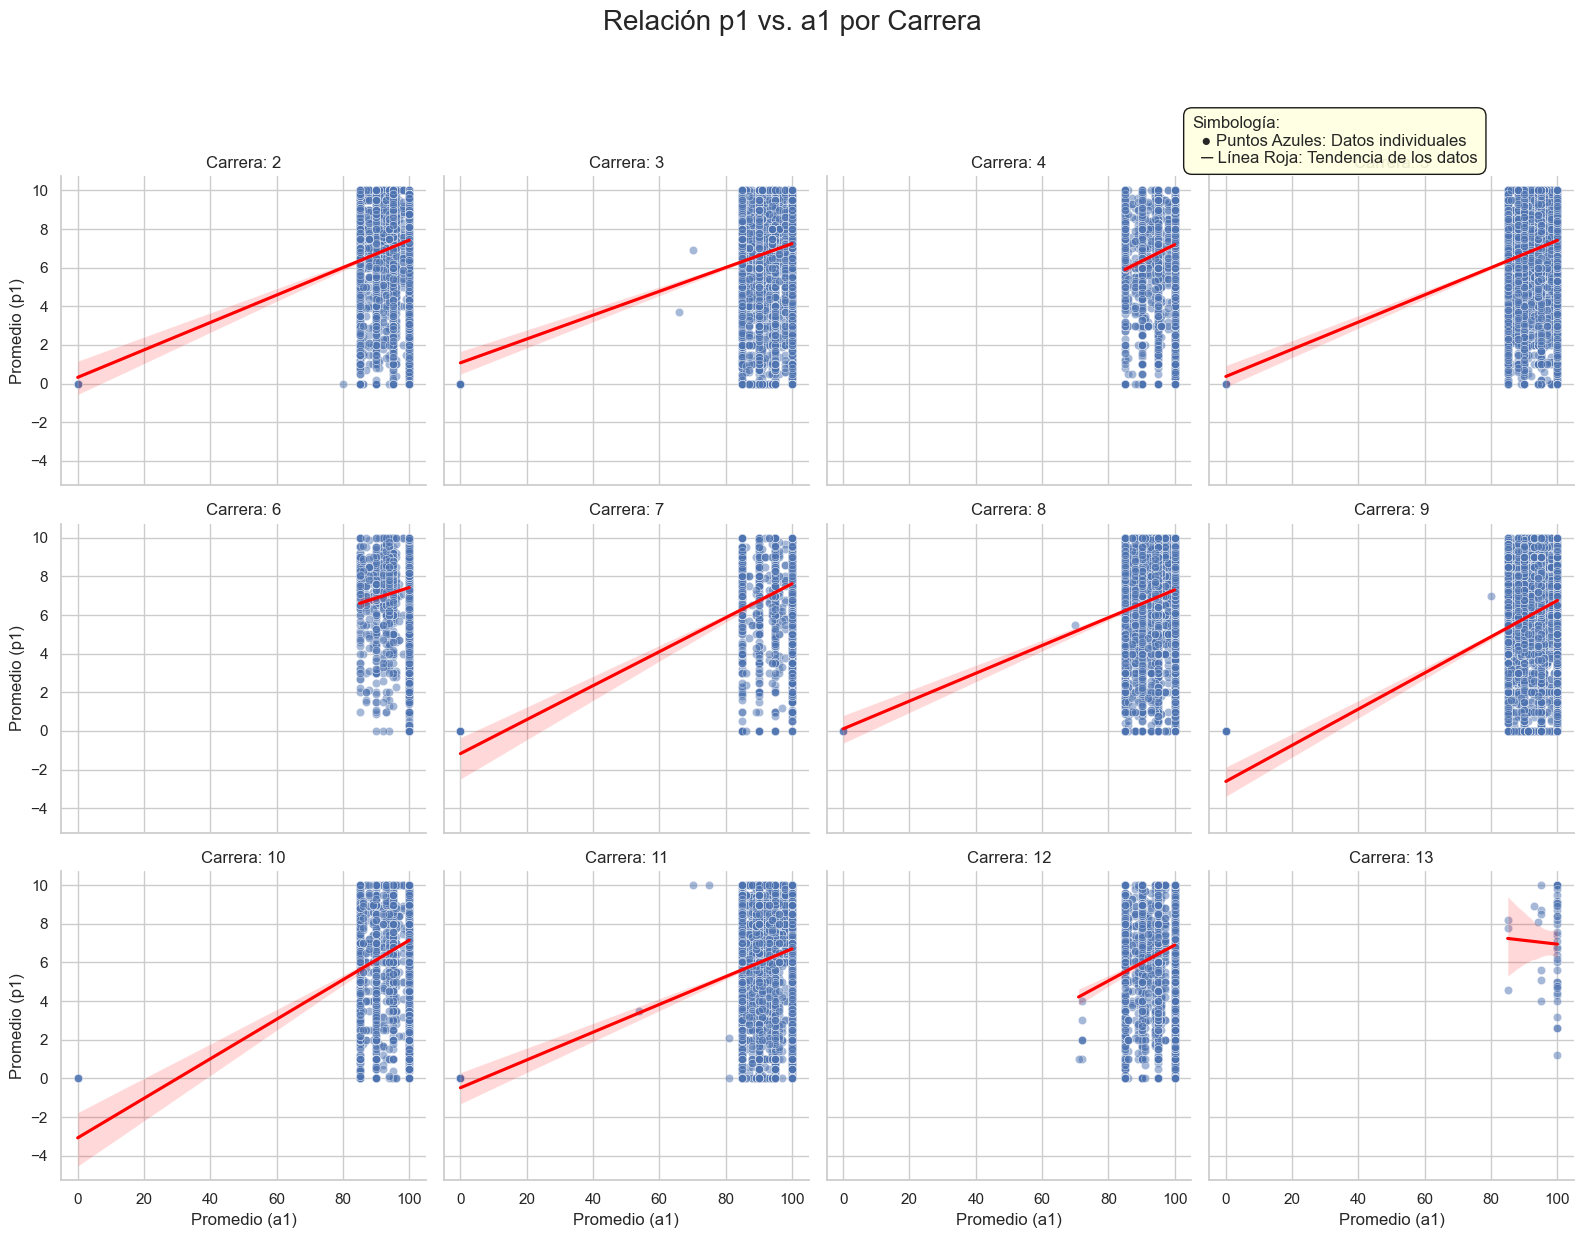

In [31]:
analisis_bivariable_por_carrera(df_etiquetado, columna1='p1', columna2='a1')


--- 2. Iniciando Análisis Bivariable por Carrera ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\3493294603.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


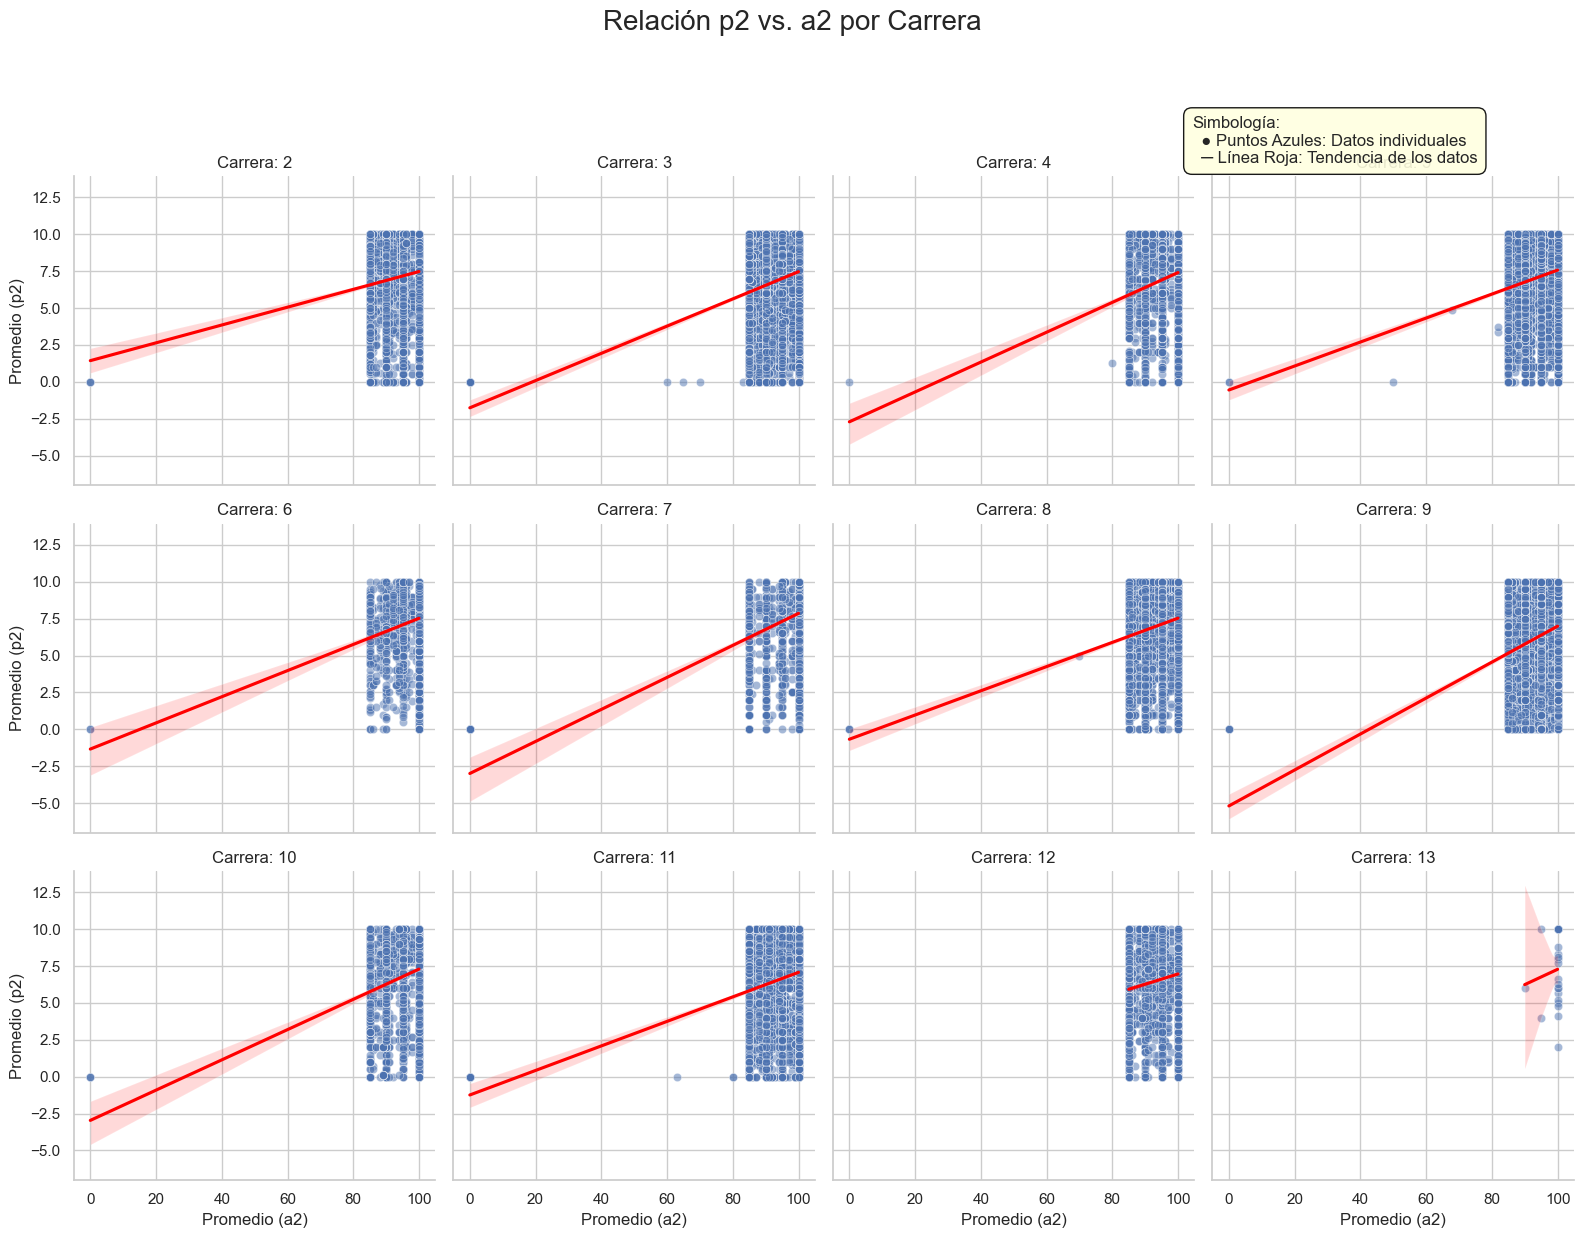

In [32]:
analisis_bivariable_por_carrera(df_etiquetado, columna1='p2', columna2='a2')


--- 2. Iniciando Análisis Bivariable por Carrera ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\3493294603.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


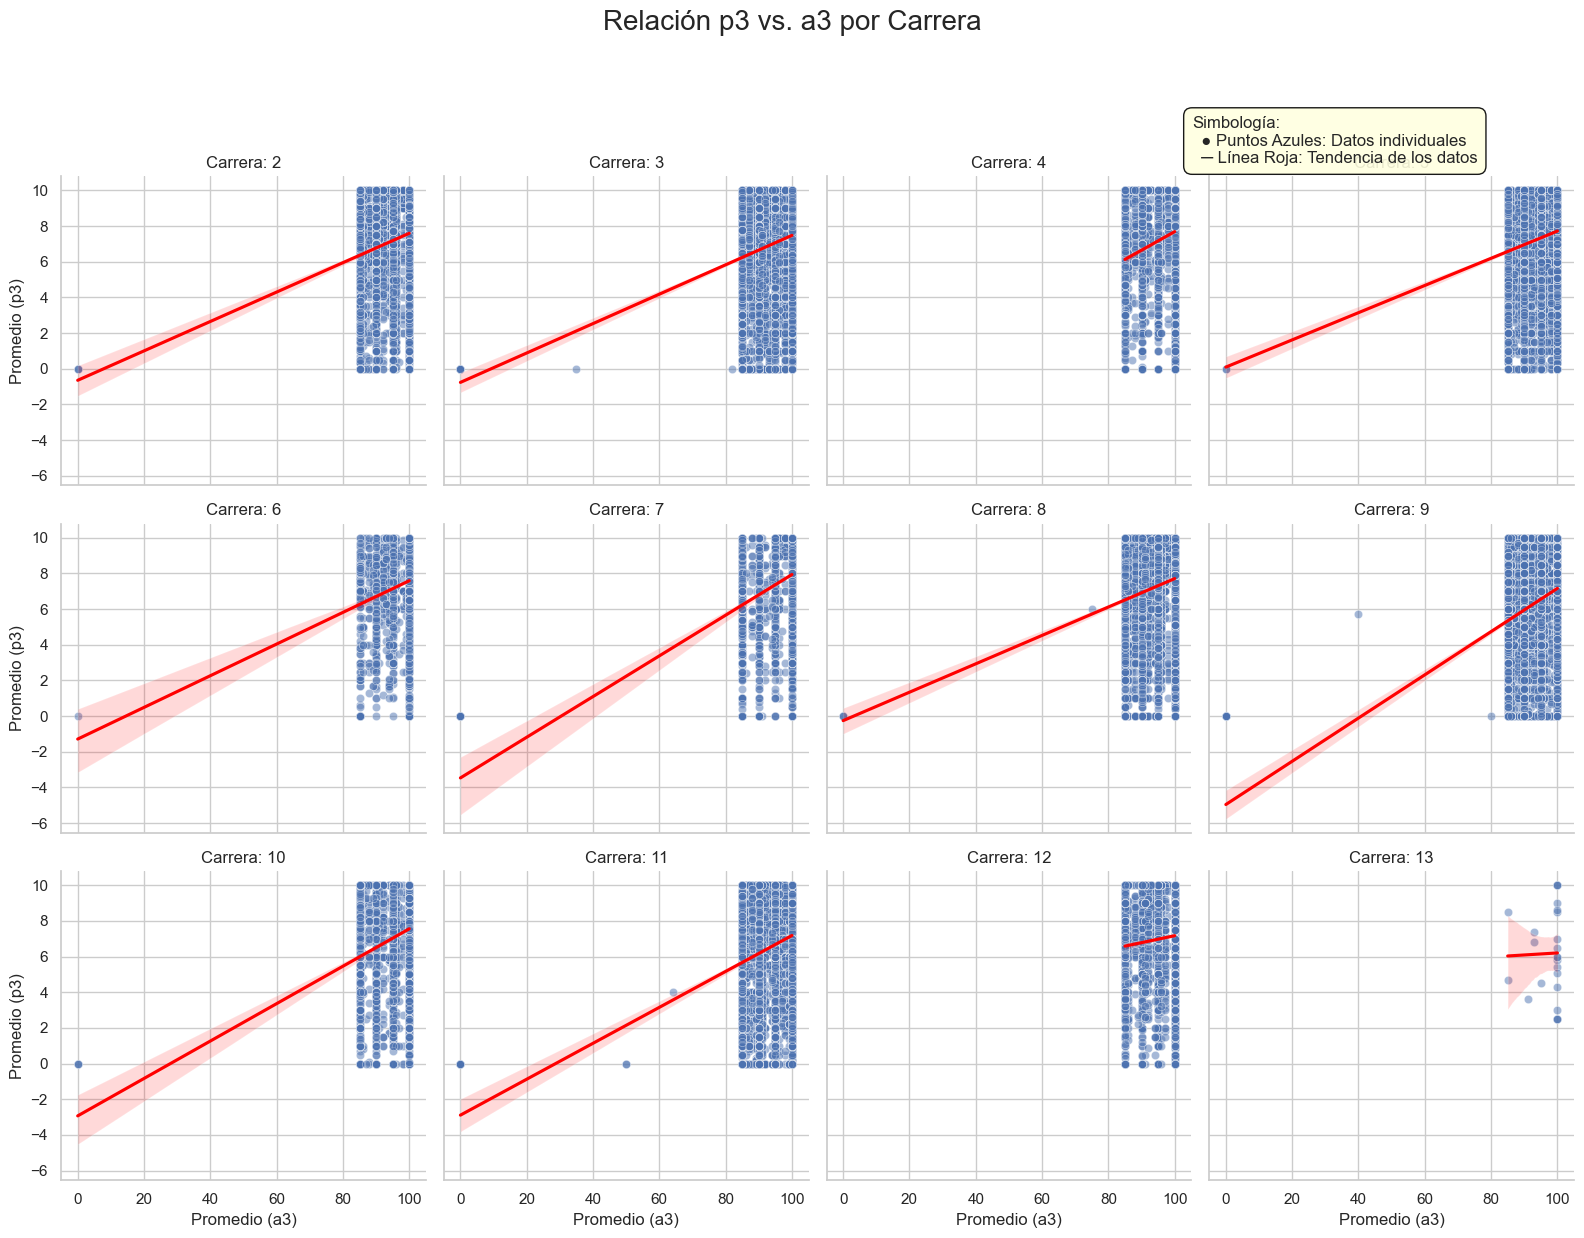

In [33]:
analisis_bivariable_por_carrera(df_etiquetado, columna1='p3', columna2='a3')


--- 2. Iniciando Análisis Bivariable por Carrera ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\3493294603.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


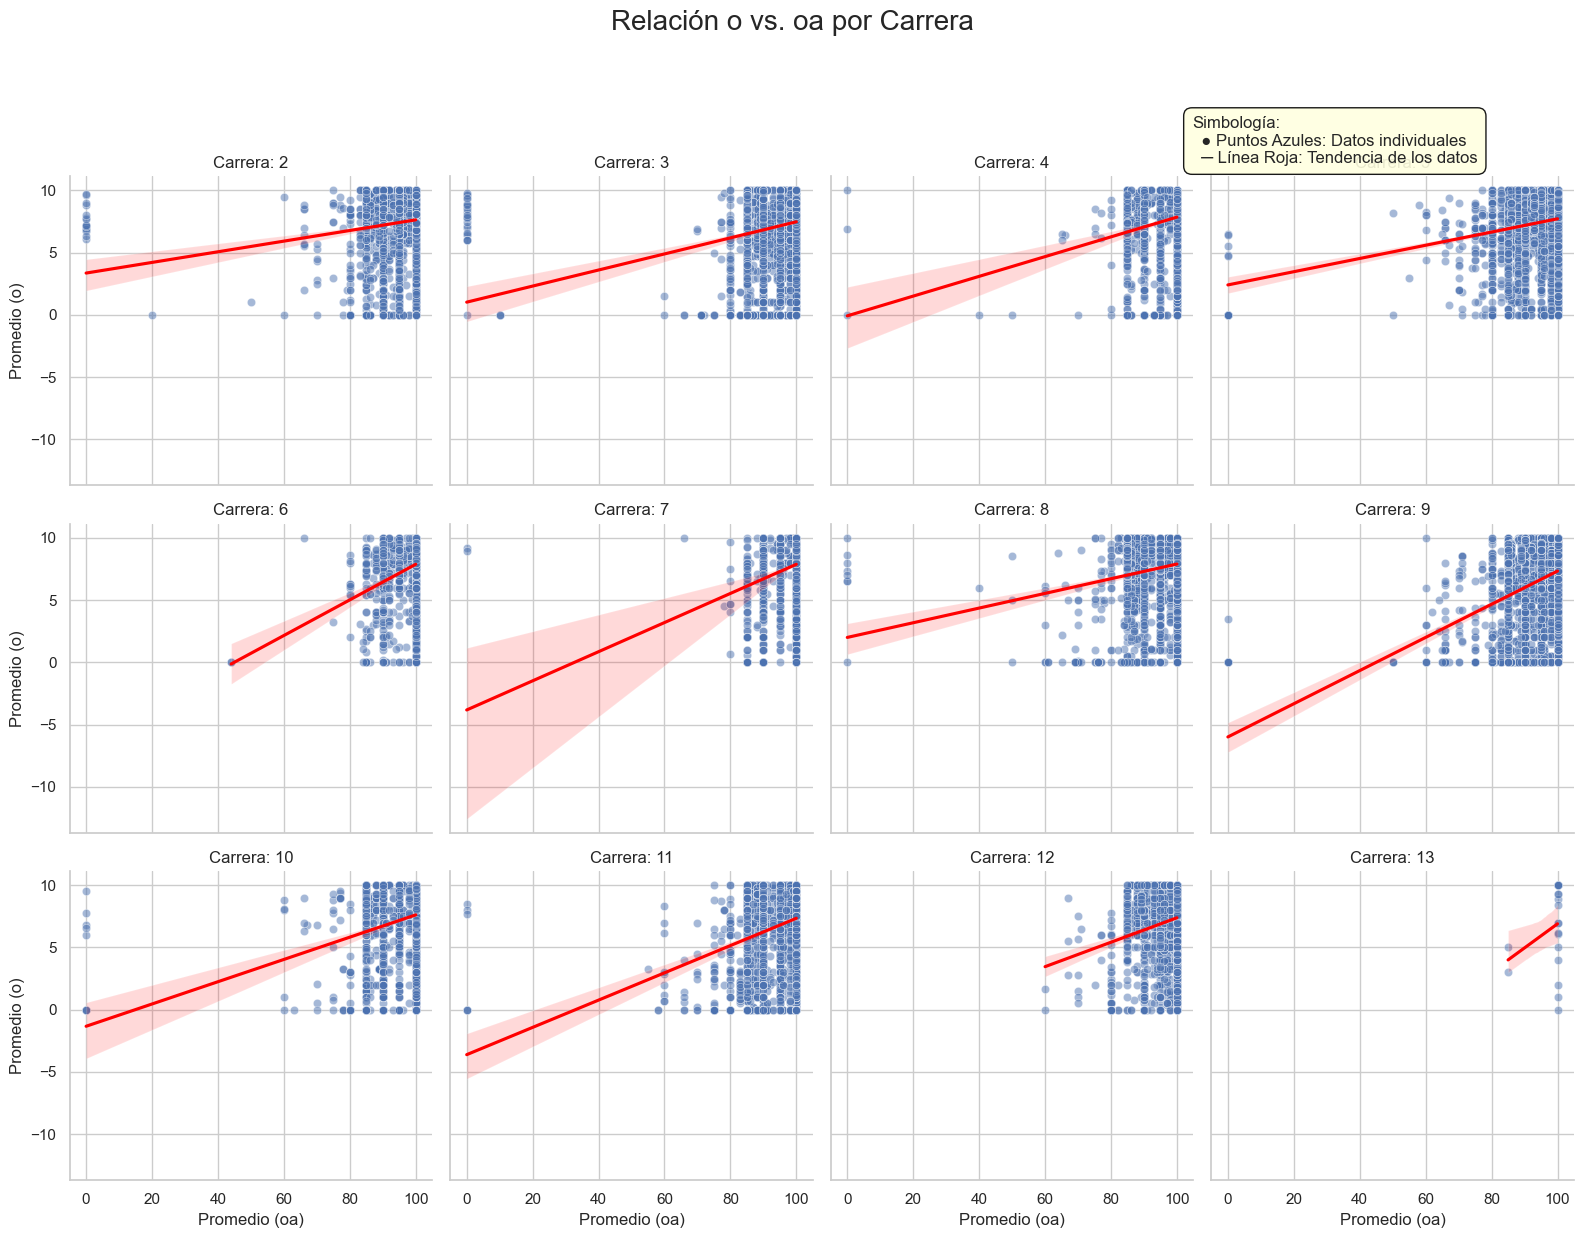

In [34]:
analisis_bivariable_por_carrera(df_etiquetado, columna1='o', columna2='oa')


--- 2. Iniciando Análisis Bivariable por Carrera ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_7960\3493294603.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


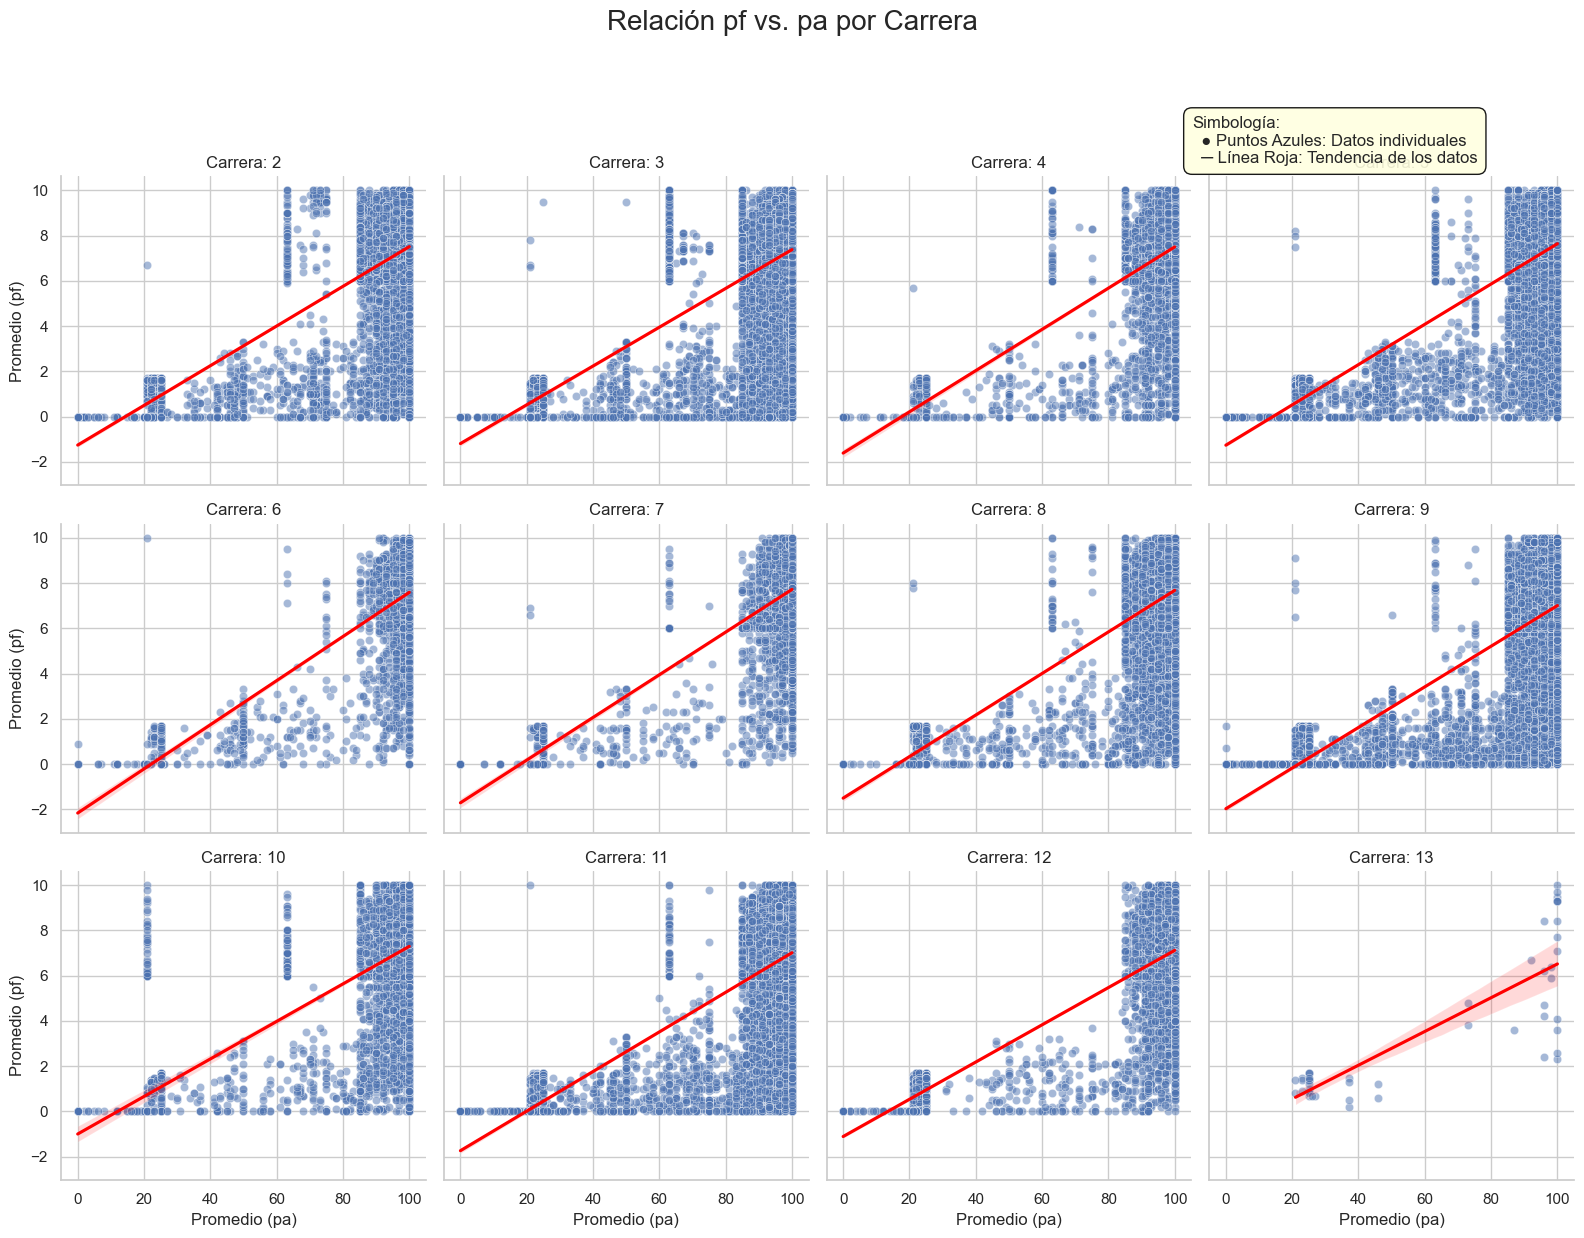

In [35]:
analisis_bivariable_por_carrera(df_etiquetado, columna1='pf', columna2='pa')

# Categorizar las asistencias

In [36]:
def categorizar_asistencias(df):
    """
    Convierte las columnas numéricas de asistencia en categóricas basadas en rangos.

    Args:
        df (pd.DataFrame): El DataFrame con los datos limpios.

    Returns:
        pd.DataFrame: El DataFrame con las nuevas columnas de asistencia categórica.
    """
    print("--- Convirtiendo Asistencias a Datos Categóricos ---")
    
    columnas_asistencia = ['a1', 'a2', 'a3', 'oa', 'pa']
    
    bins = [-1, 79.99, 84.99, 89.99, 94.99, 101]
    labels = ['1. Riesgo (<80%)', '2. Regular (80-84%)', '3. Bueno (85-89%)', '4. Muy Bueno (90-94%)', '5. Excelente (>=95%)']

    for col in columnas_asistencia:
        if col in df.columns:
            cat_col_name = f"{col}_cat"
            
            # Usamos pd.cut para segmentar los datos en los bins definidos
            df[cat_col_name] = pd.cut(df[col], bins=bins, labels=labels, right=True)
            print(f"  Columna '{cat_col_name}' creada.")
            
    return df

In [37]:
def visualizar_distribucion_asistencia_cat(df, col):
    """
    Muestra un gráfico de conteo para ver la distribución de la nueva
    categoría de asistencia final ('pa_cat').
    """
    print("\n--- Visualizando la Distribución de Asistencia Categórica ---")
    
    if 'pa_cat' not in df.columns:
        print("ERROR: La columna 'pa_cat' no existe. Ejecuta 'categorizar_asistencias' primero.")
        return

    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, x=col, order=df[col].cat.categories)
    plt.title('Distribución de Registros por Categoría de Asistencia '+ col, fontsize=16)
    plt.xlabel('Categoría de Asistencia ' + col, fontsize=12)
    plt.ylabel('Cantidad de Registros', fontsize=12)
    plt.xticks(rotation=15)
    plt.show()

In [38]:
df_final_etiquietado_categorizado = categorizar_asistencias(df_etiquetado)
        
print("\nVista previa de las nuevas columnas:")
print(df_final_etiquietado_categorizado[['pa', 'pa_cat']].head(10))

--- Convirtiendo Asistencias a Datos Categóricos ---
  Columna 'a1_cat' creada.
  Columna 'a2_cat' creada.
  Columna 'a3_cat' creada.
  Columna 'oa_cat' creada.
  Columna 'pa_cat' creada.

Vista previa de las nuevas columnas:
     pa            pa_cat
0  25.0  1. Riesgo (<80%)
1  25.0  1. Riesgo (<80%)
2  22.0  1. Riesgo (<80%)
3  23.0  1. Riesgo (<80%)
4  25.0  1. Riesgo (<80%)
5  25.0  1. Riesgo (<80%)
6  22.0  1. Riesgo (<80%)
7  21.0  1. Riesgo (<80%)
8  21.0  1. Riesgo (<80%)
9  21.0  1. Riesgo (<80%)



--- Visualizando la Distribución de Asistencia Categórica ---


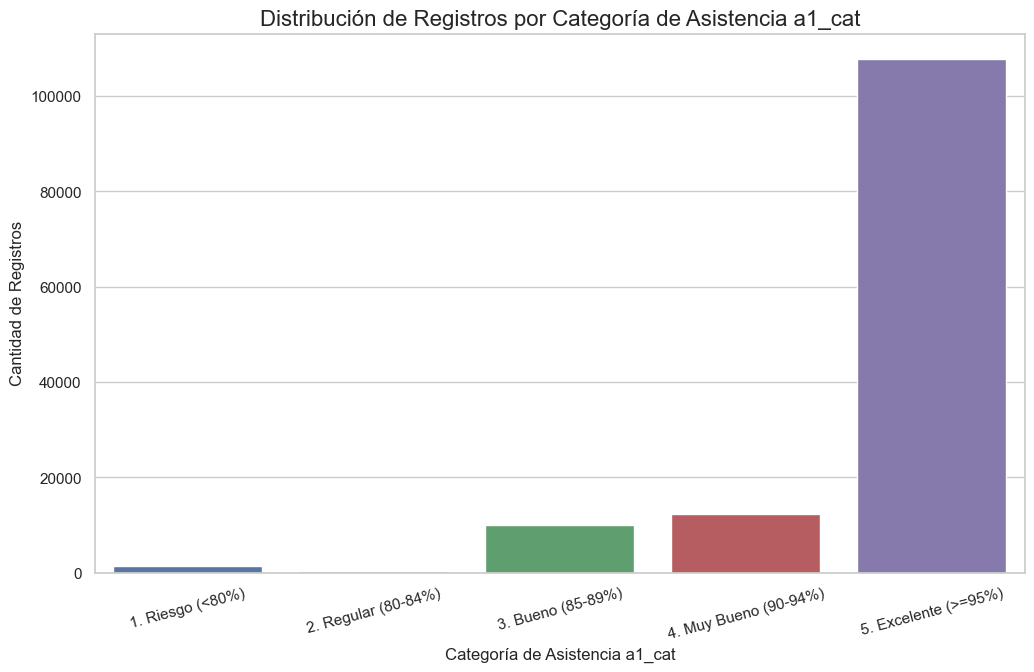

In [39]:
visualizar_distribucion_asistencia_cat(df_final_etiquietado_categorizado, "a1_cat")


--- Visualizando la Distribución de Asistencia Categórica ---


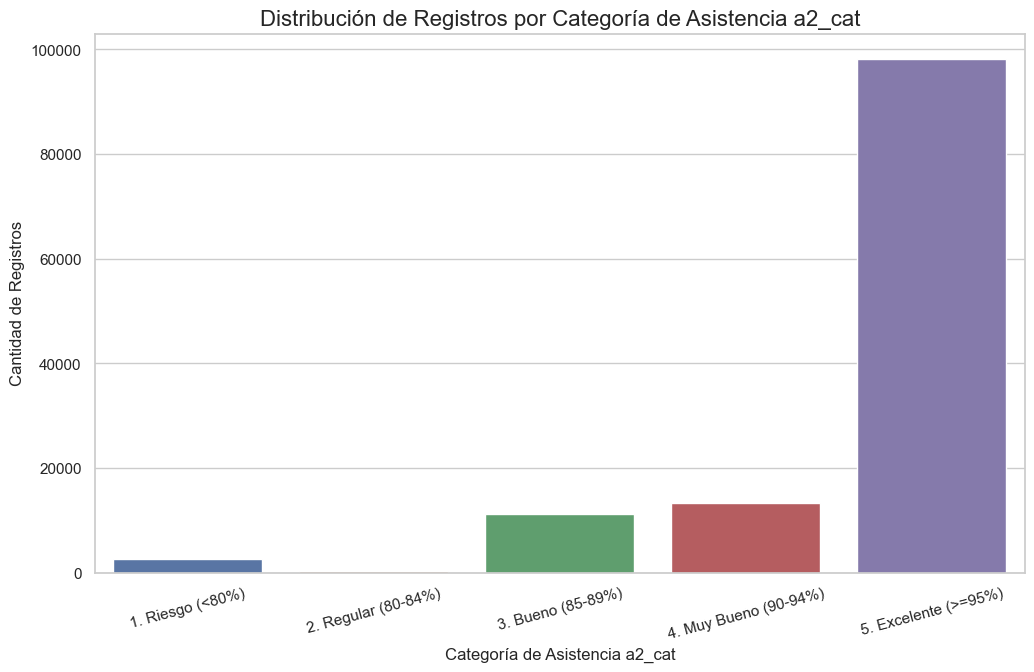

In [40]:
visualizar_distribucion_asistencia_cat(df_final_etiquietado_categorizado, "a2_cat")


--- Visualizando la Distribución de Asistencia Categórica ---


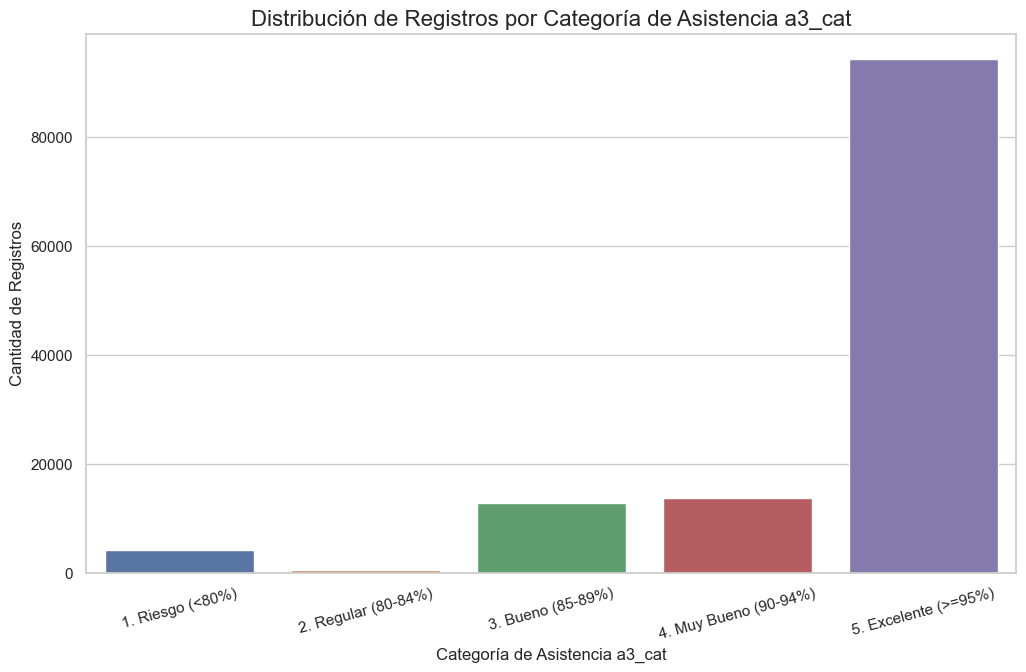

In [41]:
visualizar_distribucion_asistencia_cat(df_final_etiquietado_categorizado, "a3_cat")


--- Visualizando la Distribución de Asistencia Categórica ---


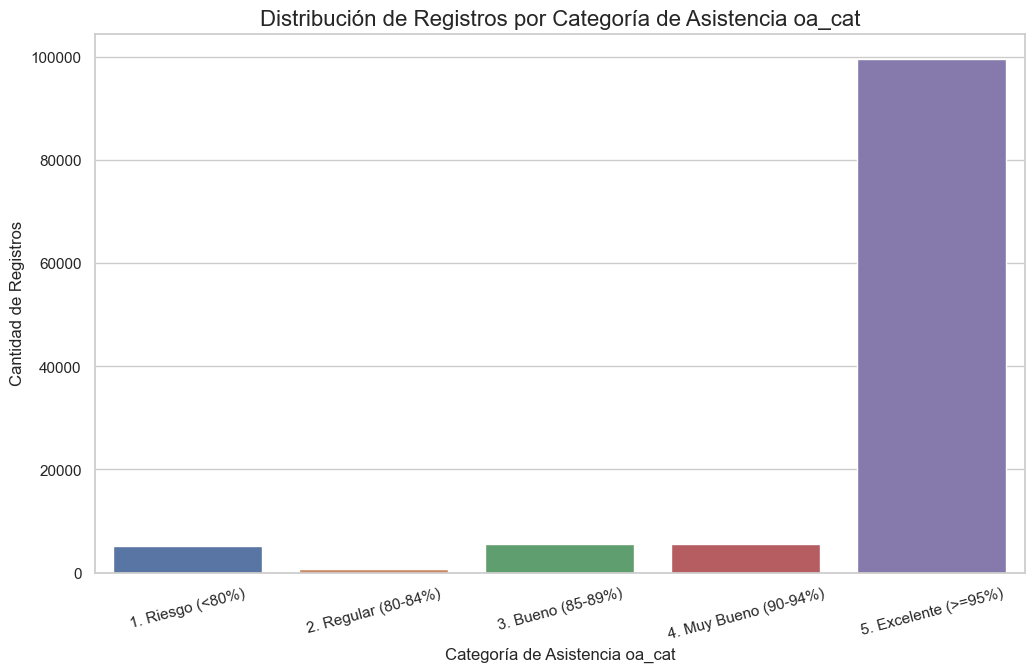

In [42]:
visualizar_distribucion_asistencia_cat(df_final_etiquietado_categorizado, "oa_cat")


--- Visualizando la Distribución de Asistencia Categórica ---


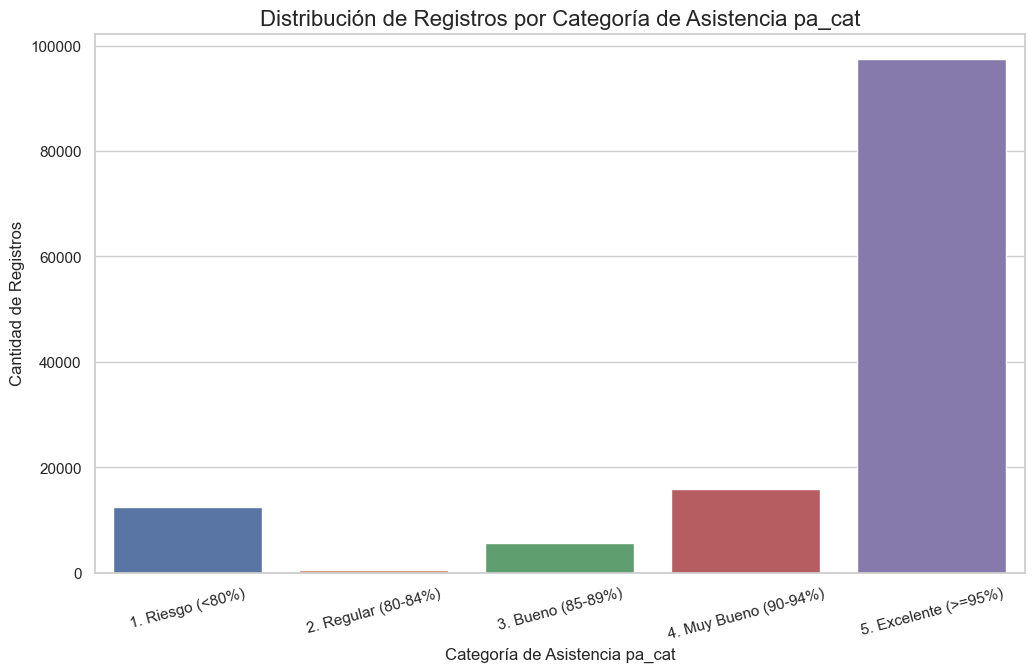

In [43]:
visualizar_distribucion_asistencia_cat(df_final_etiquietado_categorizado, "pa_cat")

In [44]:
def analisis_bivariable_categorico(df, col1="pf", col2= "pa_cat"):
    """
    Compara la distribución de una variable numérica (calificaciones)
    a través de las diferentes categorías de asistencia usando un box plot.
    """
    print("--- Iniciando Análisis Bivariable (Calificación vs. Asistencia Categórica) ---")

    if col1 not in df.columns or col2 not in df.columns:
        print("ERROR: El DataFrame debe contener " + col1 + " y " + col2 + ".")
        print("Asegúrate de haber ejecutado la limpieza y la categorización primero.")
        return

    plt.figure(figsize=(14, 8))
    sns.boxplot(
        data=df,
        x=col2,
        y=col1,
        order=['1. Riesgo (<80%)', '2. Regular (80-84%)', '3. Bueno (85-89%)', '4. Muy Bueno (90-94%)', '5. Excelente (>=95%)']
    )

    plt.title('Distribución de Calificaciones por Categoría de Asistencia', fontsize=18)
    plt.xlabel('Categoría de Asistencia ' + col2, fontsize=12)
    plt.ylabel('Calificación ' + col1, fontsize=12)
    plt.xticks(rotation=10)
    plt.show()

--- Iniciando Análisis Bivariable (Calificación vs. Asistencia Categórica) ---


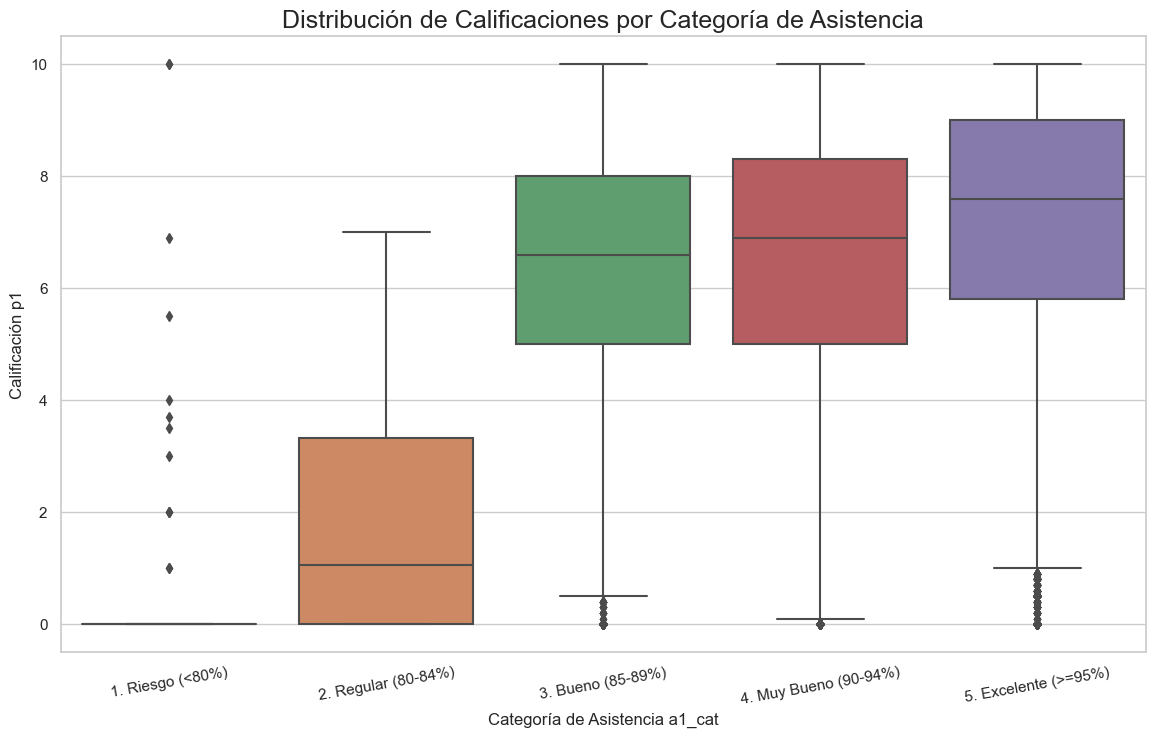

In [45]:
analisis_bivariable_categorico(df_final_etiquietado_categorizado, col1="p1", col2="a1_cat")

--- Iniciando Análisis Bivariable (Calificación vs. Asistencia Categórica) ---


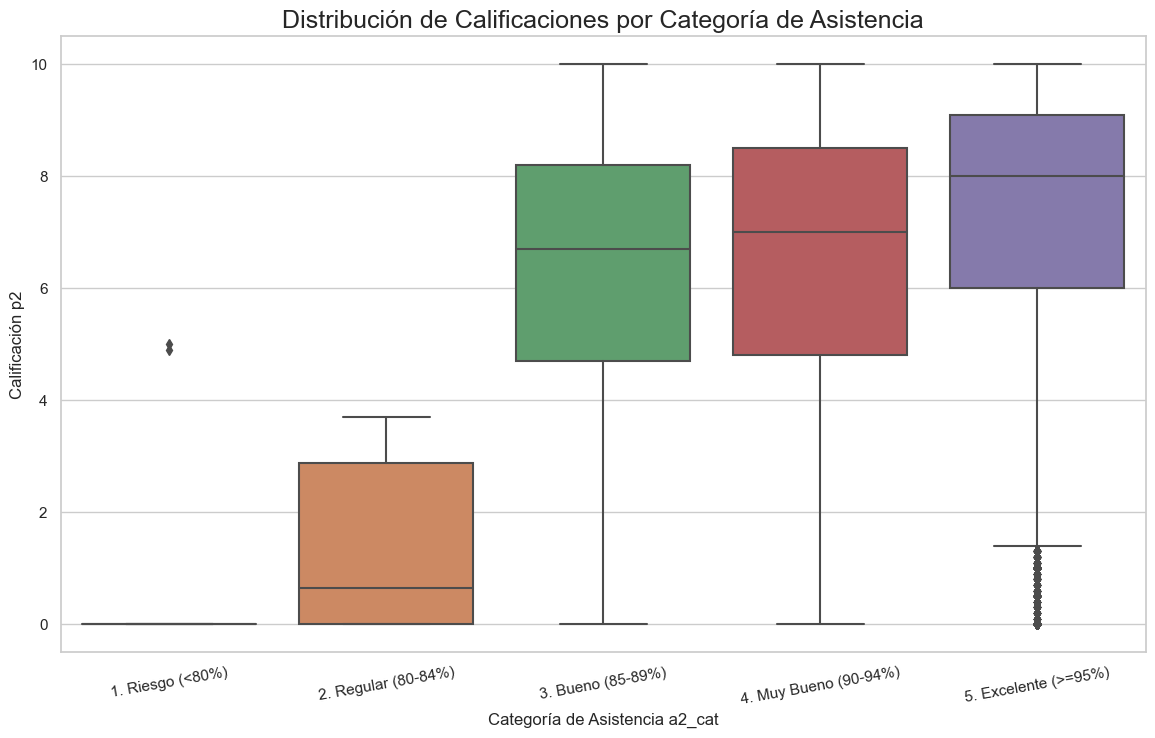

In [46]:
analisis_bivariable_categorico(df_final_etiquietado_categorizado, col1="p2", col2="a2_cat")

--- Iniciando Análisis Bivariable (Calificación vs. Asistencia Categórica) ---


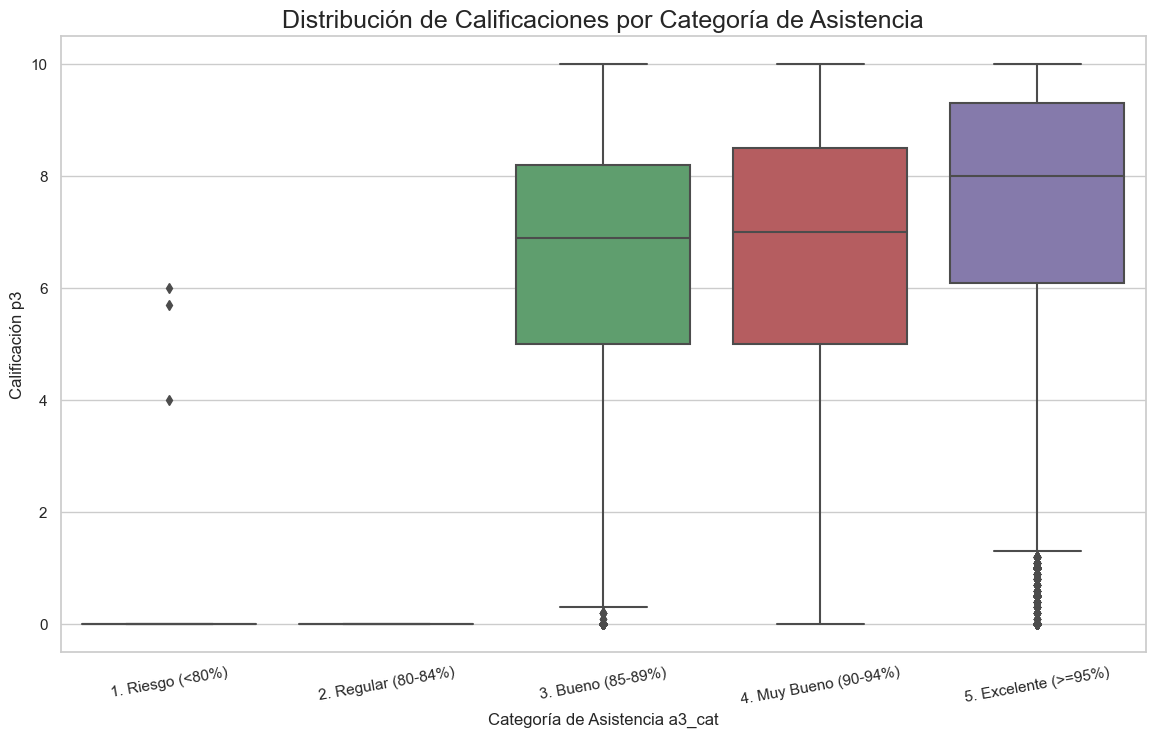

In [47]:
analisis_bivariable_categorico(df_final_etiquietado_categorizado, col1="p3", col2="a3_cat")

--- Iniciando Análisis Bivariable (Calificación vs. Asistencia Categórica) ---


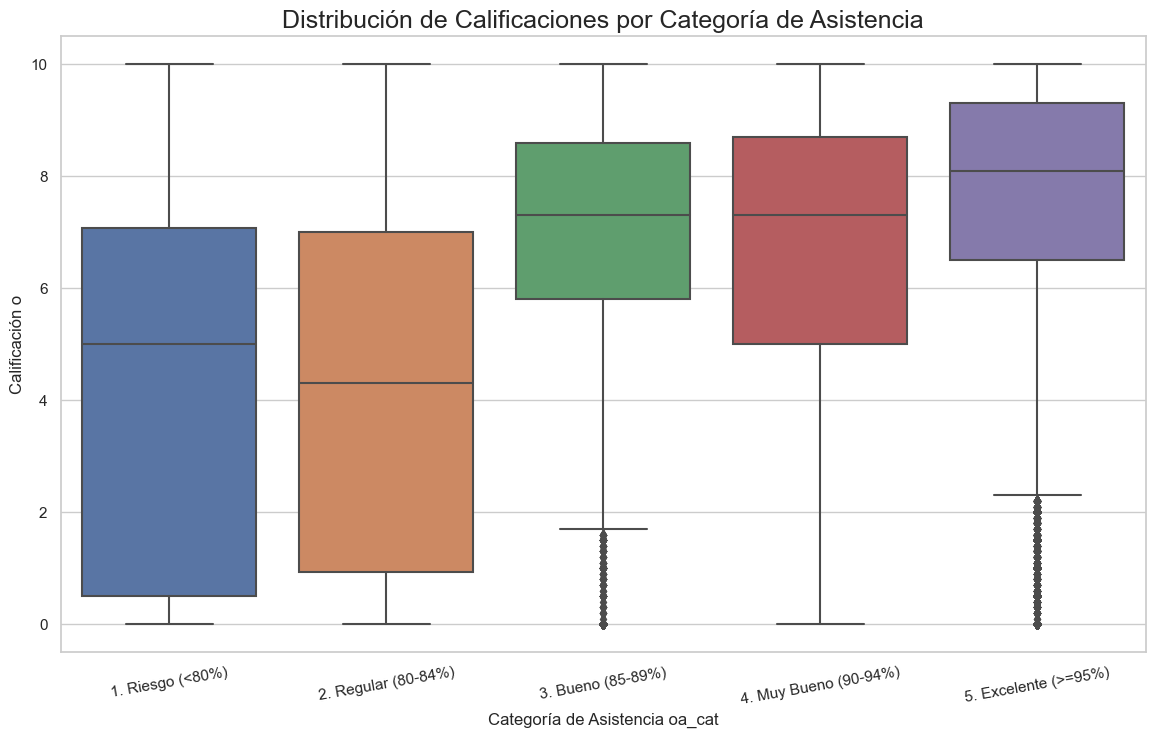

In [48]:
analisis_bivariable_categorico(df_final_etiquietado_categorizado, col1="o", col2="oa_cat")

--- Iniciando Análisis Bivariable (Calificación vs. Asistencia Categórica) ---


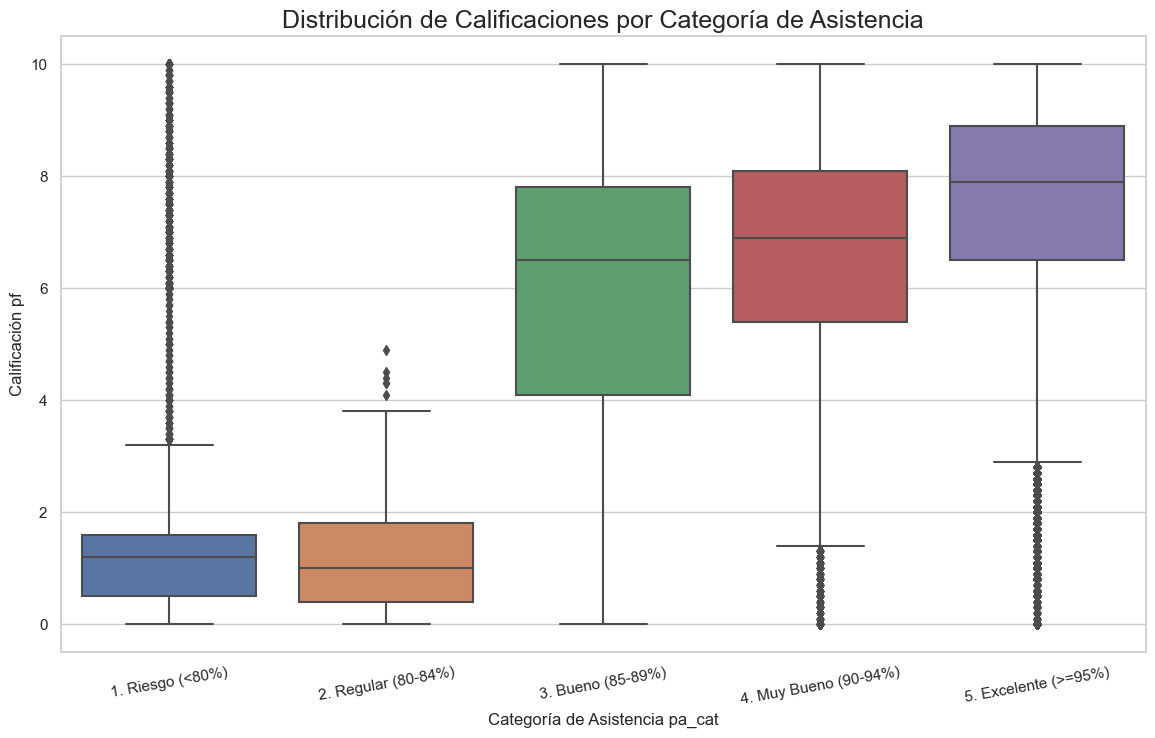

In [49]:
analisis_bivariable_categorico(df_final_etiquietado_categorizado, col1="pf", col2="pa_cat")

In [50]:
def visualizar_matriz_correlacion_con_categorias(df):
    """
    Calcula y visualiza una matriz de correlación incluyendo las calificaciones
    numéricas y las asistencias categóricas (usando One-Hot Encoding).
    """
    print("\n--- Generando Matriz de Correlación con Asistencias Categóricas ---")
    
    columnas_calificaciones = ['p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp']
    df_calificaciones = df[columnas_calificaciones].copy()

    columnas_cat_asistencia = ['a1_cat','a2_cat','a3_cat','oa_cat','pa_cat']
    
    df_asistencia_encoded = pd.get_dummies(df[columnas_cat_asistencia])
    
    df_para_corr = pd.concat([df_calificaciones, df_asistencia_encoded], axis=1)
    
    print("Columnas incluidas en la correlación:")
    print(df_para_corr.columns.tolist())
    
    matriz_corr = df_para_corr.corr(method='pearson')
    
    plt.figure(figsize=(18, 14))
    sns.heatmap(
        matriz_corr,
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        linewidths=0.5
    )
    plt.title('Matriz de Correlación: Calificaciones vs. Asistencias Categóricas', fontsize=20)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


--- Generando Matriz de Correlación con Asistencias Categóricas ---
Columnas incluidas en la correlación:
['p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp', 'a1_cat_1. Riesgo (<80%)', 'a1_cat_2. Regular (80-84%)', 'a1_cat_3. Bueno (85-89%)', 'a1_cat_4. Muy Bueno (90-94%)', 'a1_cat_5. Excelente (>=95%)', 'a2_cat_1. Riesgo (<80%)', 'a2_cat_2. Regular (80-84%)', 'a2_cat_3. Bueno (85-89%)', 'a2_cat_4. Muy Bueno (90-94%)', 'a2_cat_5. Excelente (>=95%)', 'a3_cat_1. Riesgo (<80%)', 'a3_cat_2. Regular (80-84%)', 'a3_cat_3. Bueno (85-89%)', 'a3_cat_4. Muy Bueno (90-94%)', 'a3_cat_5. Excelente (>=95%)', 'oa_cat_1. Riesgo (<80%)', 'oa_cat_2. Regular (80-84%)', 'oa_cat_3. Bueno (85-89%)', 'oa_cat_4. Muy Bueno (90-94%)', 'oa_cat_5. Excelente (>=95%)', 'pa_cat_1. Riesgo (<80%)', 'pa_cat_2. Regular (80-84%)', 'pa_cat_3. Bueno (85-89%)', 'pa_cat_4. Muy Bueno (90-94%)', 'pa_cat_5. Excelente (>=95%)']


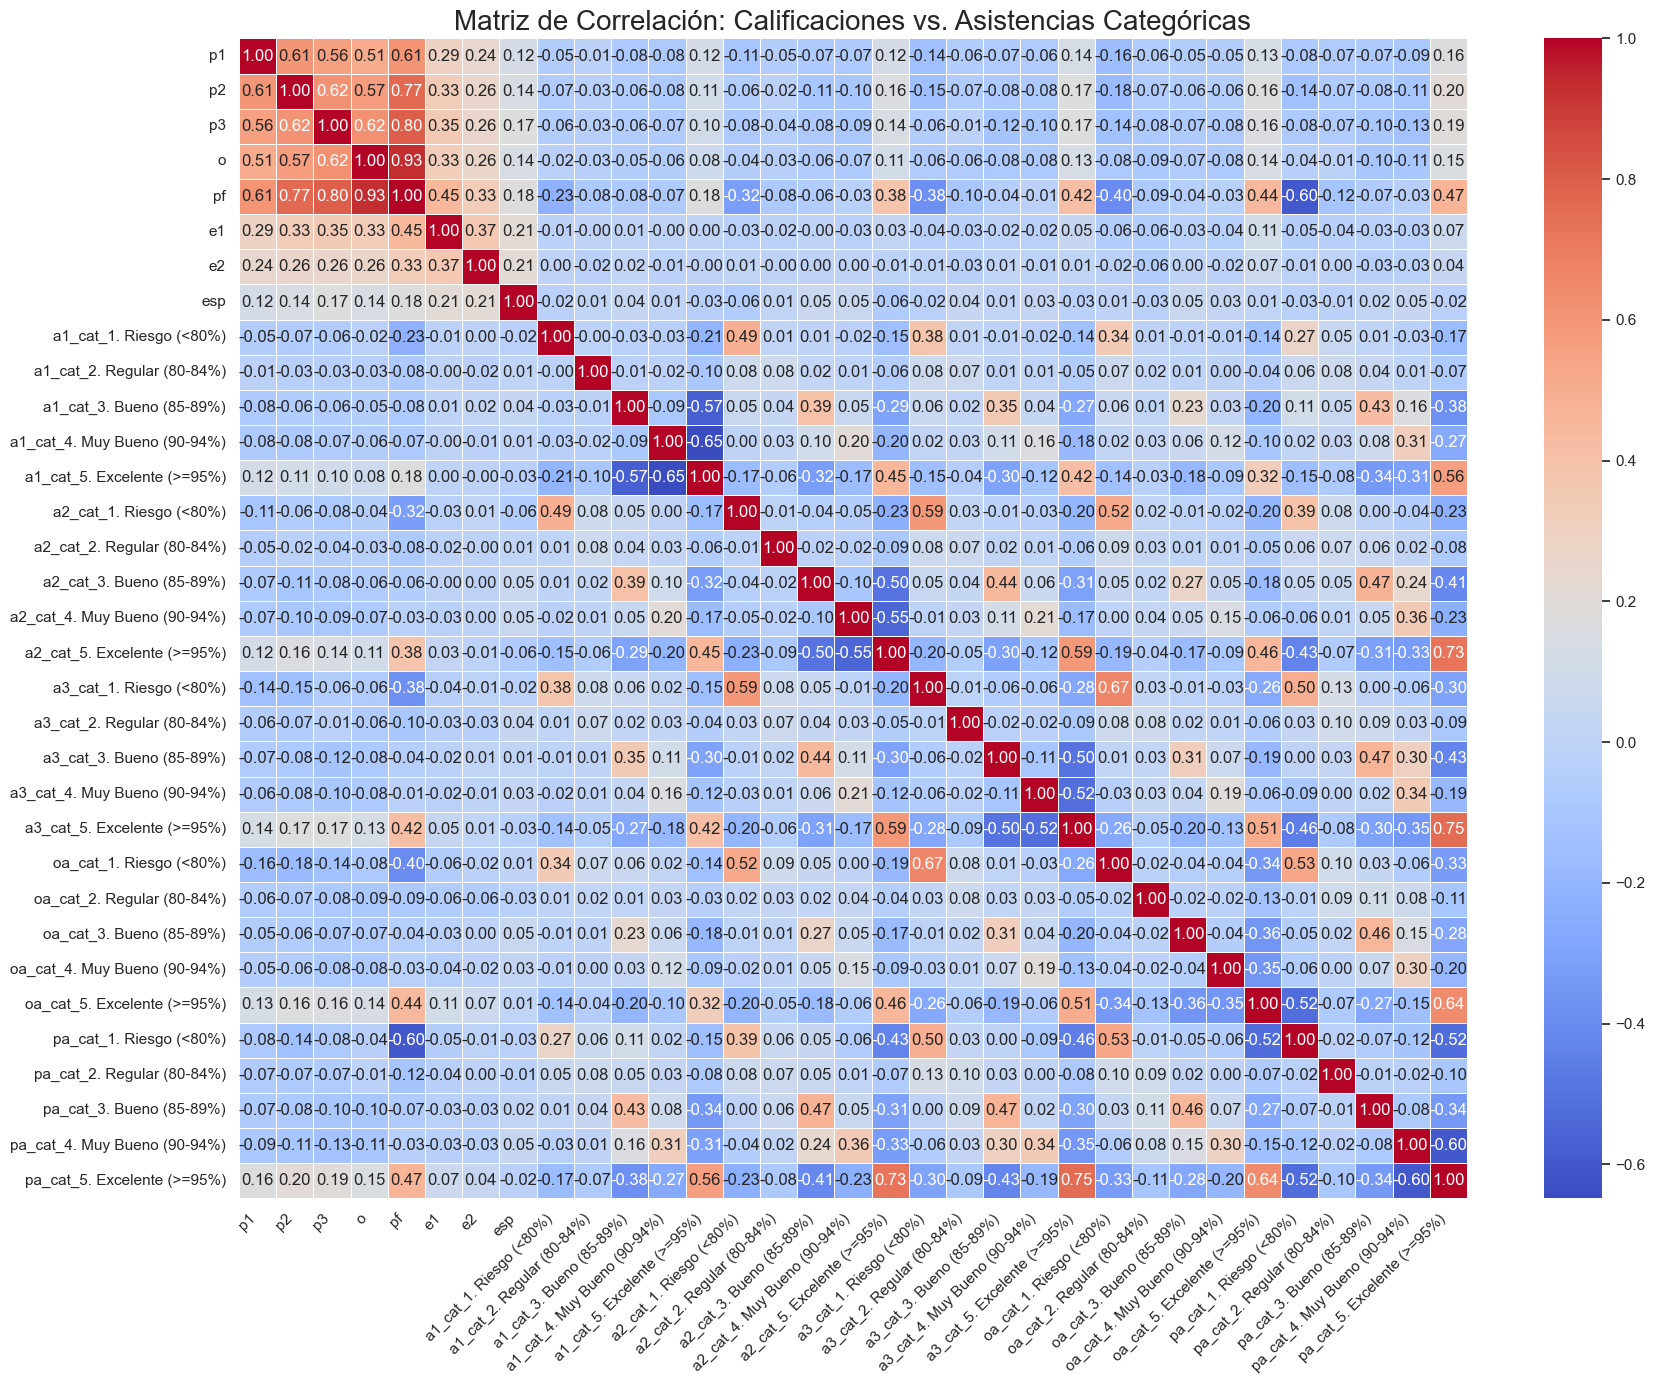

In [51]:
visualizar_matriz_correlacion_con_categorias(df_final_etiquietado_categorizado)

In [52]:
df_final_etiquietado_categorizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133882 entries, 0 to 133881
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   id_carrera           133882 non-null  int64   
 1   id_grupo             133882 non-null  int64   
 2   id_materia           133882 non-null  int64   
 3   semestre             133882 non-null  int64   
 4   periodo              133882 non-null  int64   
 5   p1                   129147 non-null  float64 
 6   p2                   121702 non-null  float64 
 7   p3                   119228 non-null  float64 
 8   o                    118443 non-null  float64 
 9   pf                   131794 non-null  float64 
 10  e1                   16785 non-null   float64 
 11  e2                   8892 non-null    float64 
 12  esp                  1021 non-null    float64 
 13  a1                   131697 non-null  float64 
 14  a2                   125586 non-null  float64 
 15  

# Regresion logistica
## Como los alumnos aparecen varias veces en el dataset, ocuparemos screenshots de cada periodo

In [55]:
def crear_dataset_snapshots_final(df):
    print("--- Creando dataset de 'instantáneas' para el modelo ---")
    
    cols_a_rellenar = ['p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp', 'a1', 'a2', 'a3', 'oa', 'pa']
    df[cols_a_rellenar] = df[cols_a_rellenar].fillna(0)

    snapshot_list = []
    
    grouped = df.groupby('alumno_carrera_hash')
    
    print(f"Procesando {len(grouped)} perfiles de alumno-carrera...")
    for student_hash, data in grouped:
        resultado_final = data['resultado_final'].iloc[0]
        id_carrera_alumno = data['id_carrera'].iloc[0]
        
        data = data.sort_values(by='periodo').reset_index(drop=True)
        
        for semestre_cursado in sorted(data['semestre'].unique()):
            snapshot_data = data[data['semestre'] <= semestre_cursado]
            snapshot_features = {
                'semestre_actual': semestre_cursado,
                'id_carrera': id_carrera_alumno,
                'promedio_calificacion_final': snapshot_data['pf'].mean(),
                'promedio_asistencia_final': snapshot_data['pa'].mean(),
                'materias_cursadas': snapshot_data.shape[0],
                'materias_reprobadas': (snapshot_data['pf'] < 6).sum(),
                'std_calificacion_final': snapshot_data['pf'].std(ddof=0),
                'resultado_final': resultado_final
            }
            snapshot_list.append(snapshot_features)

    snapshot_df = pd.DataFrame(snapshot_list).fillna(0)
    print("¡Dataset de 'instantáneas' creado exitosamente!")
    return snapshot_df

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [57]:
snapshot_dataset = crear_dataset_snapshots_final(df_final_etiquietado_categorizado)

X = snapshot_dataset.drop('resultado_final', axis=1)
y = snapshot_dataset['resultado_final']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['id_carrera']
if 'id_carrera' in numeric_features:
    numeric_features.remove('id_carrera')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
print("\n--- Entrenando el modelo de Regresión Logística ---")
pipeline.fit(X_train, y_train)
print("¡Entrenamiento completado!")

y_pred = pipeline.predict(X_test)

print("\n" + "="*50)
print(" " * 15 + "EVALUACIÓN DEL MODELO")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Terminó (0)', 'Sí Terminó (1)']))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n" + "="*60)
print(" " * 10 + "INTERPRETACIÓN DE LOS COEFICIENTES DEL MODELO")
print("="*60)

feature_names_raw = pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_names = [name.split('__')[-1] for name in feature_names_raw]
coefficients = pipeline.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({'Característica': feature_names, 'Coeficiente (Peso)': coefficients})
coef_df['Impacto en Odds'] = np.exp(coef_df['Coeficiente (Peso)'])

print(coef_df.sort_values(by='Coeficiente (Peso)', ascending=False))
print("\n" + "-"*60)
print("Interpretación del 'Impacto en Odds':")
print("- Valor > 1.0: Al aumentar esta característica, AUMENTA la probabilidad de terminar.")
print("- Valor < 1.0: Al aumentar esta característica, DISMINUYE la probabilidad de terminar.")
print("  (Ej: 1.25 = 25% más de 'odds' de terminar; 0.80 = 20% menos de 'odds' de terminar).")

--- Creando dataset de 'instantáneas' para el modelo ---
Procesando 5705 perfiles de alumno-carrera...
¡Dataset de 'instantáneas' creado exitosamente!

--- Entrenando el modelo de Regresión Logística ---
¡Entrenamiento completado!

               EVALUACIÓN DEL MODELO
Accuracy: 0.7949

Reporte de Clasificación:
                precision    recall  f1-score   support

No Terminó (0)       0.72      0.82      0.77      3130
Sí Terminó (1)       0.86      0.78      0.82      4564

      accuracy                           0.79      7694
     macro avg       0.79      0.80      0.79      7694
  weighted avg       0.80      0.79      0.80      7694


Matriz de Confusión:
[[2572  558]
 [1020 3544]]

          INTERPRETACIÓN DE LOS COEFICIENTES DEL MODELO
                 Característica  Coeficiente (Peso)  Impacto en Odds
0               semestre_actual            2.342642        10.408702
2     promedio_asistencia_final            0.637732         1.892184
12                 id_carrera_8    